# Breast Cancer Wisconsin (Diagnostic) — ML Project

**Corso:** Machine Learning — Universita' degli Studi di Milano-Bicocca  
**Dataset:** Breast Cancer Wisconsin (Diagnostic) — UCI ML Repository (ID=17)  
**Modelli:** SVM (Soft Margin, Kernel RBF) + Decision Tree (CART) + K-Means  
**Autori:** [Nomi]  
**Data:** [Data]

---
## 1. Description of the Domain and Objectives

### 1.1 Contesto Clinico

Il cancro al seno e' la neoplasia piu' diffusa nella popolazione femminile a livello mondiale. La diagnosi precoce e accurata e' un fattore critico per la sopravvivenza delle pazienti.

La procedura diagnostica standard prevede l'**agoaspirato con ago sottile (FNA)** della massa mammaria, seguito dall'analisi citologica al microscopio. Il patologo valuta le caratteristiche morfologiche dei nuclei cellulari per determinare se il tumore sia **benigno** o **maligno**.

### 1.2 Obiettivi

1. Costruire modelli di classificazione binaria (Maligno vs Benigno) a partire da feature morfologiche
2. Confrontare **SVM** e **Decision Tree (CART)** in termini di performance e interpretabilita'
3. Verificare con **K-Means** se i dati presentano una struttura naturale a 2 cluster
4. Identificare le feature piu' discriminanti per la diagnosi

### 1.3 Considerazioni Etiche

In ambito oncologico un **falso negativo** (tumore maligno classificato come benigno) ha un costo clinico molto piu' alto di un falso positivo. Questo guida la scelta della metrica di ottimizzazione (F1/Recall) e l'uso di `class_weight='balanced'`.

---
## 2. Setup

In [175]:
!pip install ucimlrepo -q

In [176]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from ucimlrepo import fetch_ucirepo

# Preprocessing e model selection
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Modelli supervisionati
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Modello non supervisionato
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Metriche
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay,
    silhouette_score, adjusted_rand_score
)

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 150,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

print('Setup completato.')

Setup completato.


In [177]:
# Versioni librerie (riproducibilita')
import sklearn
print(f'scikit-learn: {sklearn.__version__}')
print(f'numpy:        {np.__version__}')
print(f'pandas:       {pd.__version__}')
print(f'matplotlib:   {plt.matplotlib.__version__}')
print(f'seaborn:      {sns.__version__}')

scikit-learn: 1.6.1
numpy:        2.0.2
pandas:       2.2.2
matplotlib:   3.10.0
seaborn:      0.13.2


---
## 3. Design Choices, Hypotheses and Assumptions

### 3.1 Dataset

Il dataset **Breast Cancer Wisconsin (Diagnostic)** proviene dal UCI ML Repository (ID=17). E' stato creato presso l'Universita' del Wisconsin da immagini digitalizzate di agoaspirati FNA.

### 3.2 Struttura delle Feature

Per ciascuna delle **10 caratteristiche morfologiche base** dei nuclei cellulari vengono calcolate 3 statistiche:
- **Mean**: valore medio su tutti i nuclei dell'immagine
- **SE**: errore standard della misura
- **Worst**: media dei 3 valori piu' estremi

Totale: 10 x 3 = **30 feature numeriche continue**.

| # | Feature base | Descrizione |
|---|-------------|-------------|
| 1 | Radius | Distanza media dal centro ai punti del perimetro |
| 2 | Texture | Deviazione standard dei valori di grigio |
| 3 | Perimeter | Perimetro del nucleo |
| 4 | Area | Area del nucleo |
| 5 | Smoothness | Variazione locale nelle lunghezze dei raggi |
| 6 | Compactness | (Perimetro^2 / Area) - 1 |
| 7 | Concavity | Severita' delle porzioni concave del contorno |
| 8 | Concave points | Numero di porzioni concave |
| 9 | Symmetry | Simmetria del nucleo |
| 10 | Fractal dimension | Approssimazione coastline - 1 |

### 3.3 Assunzioni

1. **Indipendenza dei campioni**: ogni campione rappresenta un paziente distinto
2. **Qualita' delle misurazioni**: le feature sono state estratte con metodologia standardizzata e riproducibile
3. **Rappresentativita'**: il dataset e' rappresentativo della popolazione clinica di riferimento

### 3.4 Limitazioni Note

- Dataset monocentrico (singolo ospedale)
- Nessuna variabile demografica (eta', etnia, storia familiare)
- 569 campioni: sufficiente per i modelli scelti, ma non per deep learning
- Alta correlazione tra feature della stessa famiglia (radius/perimeter/area sono geometricamente dipendenti)

In [178]:
# Caricamento dataset
dataset = fetch_ucirepo(id=17)
X = dataset.data.features
y_raw = dataset.data.targets

# LabelEncoder solo sul target (mai sulle feature)
le = LabelEncoder()
y = le.fit_transform(y_raw.iloc[:, 0])  # B=0, M=1

# DataFrame unificato per EDA
df = X.copy()
df['Diagnosis'] = y_raw.iloc[:, 0]
df['Diagnosis_num'] = y

print(f'Campioni: {X.shape[0]}')
print(f'Feature:  {X.shape[1]}')
print(f'Target:   {le.classes_} -> {le.transform(le.classes_)}')

Campioni: 569
Feature:  30
Target:   ['B' 'M'] -> [0 1]


---
## 4. Exploratory Data Analysis (EDA)

### 4.1 Qualita' dei Dati

In [179]:
# Missing values
missing = X.isnull().sum()
print(f'Missing values totali: {missing.sum()}')

# Duplicati
print(f'Righe duplicate: {X.duplicated().sum()}')

# Tipi di dato
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=[object]).columns.tolist()
print(f'Feature numeriche: {len(num_cols)}')
print(f'Feature categoriche: {len(cat_cols)}')

Missing values totali: 0
Righe duplicate: 0
Feature numeriche: 30
Feature categoriche: 0


### 4.2 Distribuzione del Target

Distribuzione target:
  B: 357 (62.7%)
  M: 212 (37.3%)

Rapporto minoranza/maggioranza: 0.594
Imbalance moderato -> class_weight="balanced"


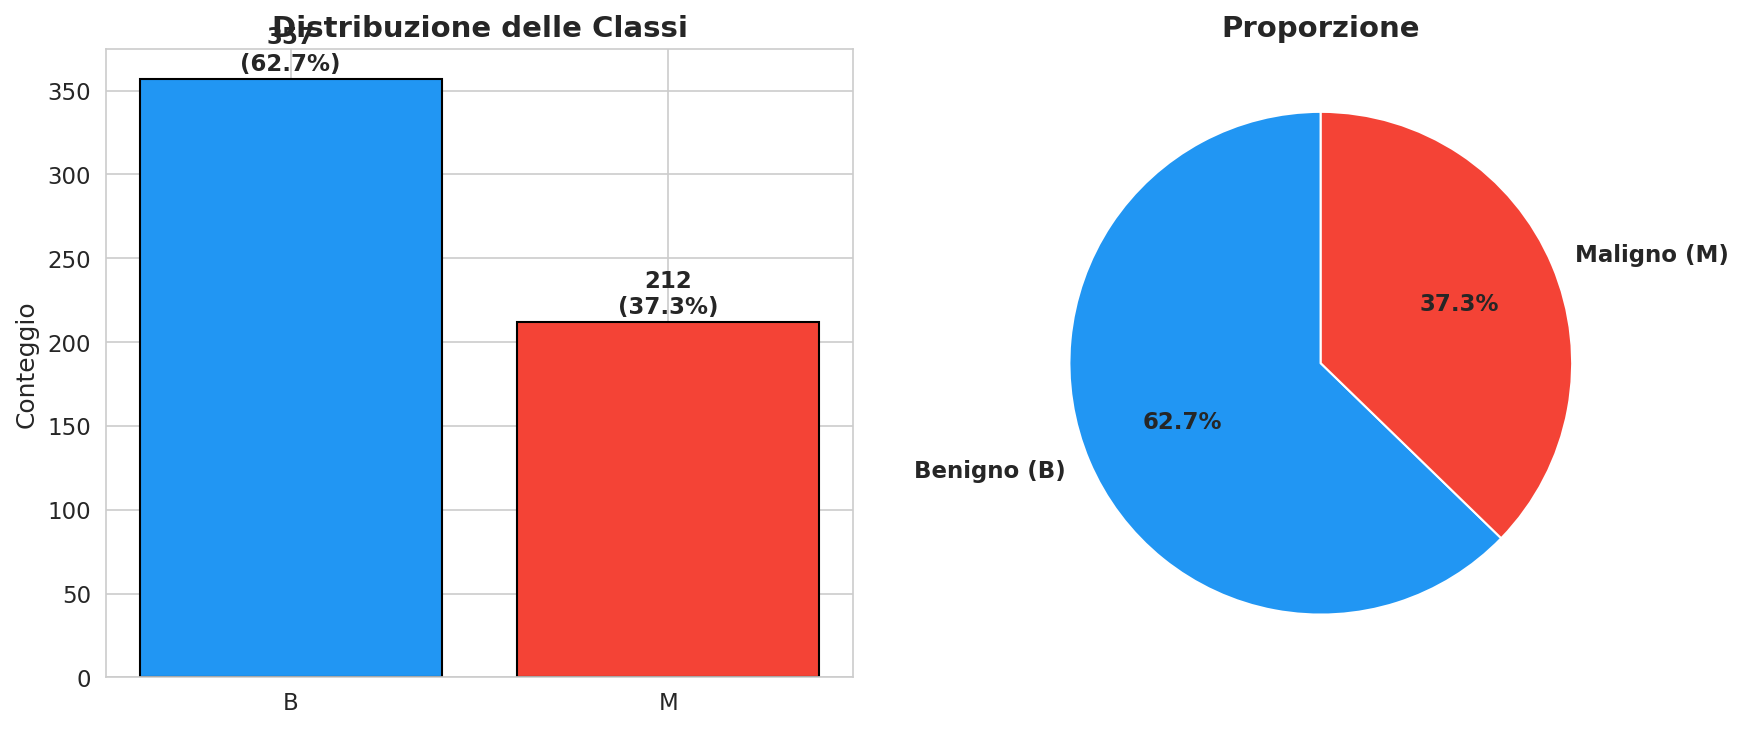

In [180]:
target_counts = df['Diagnosis'].value_counts()
print('Distribuzione target:')
for cls, count in target_counts.items():
    print(f'  {cls}: {count} ({count / len(df) * 100:.1f}%)')

ratio = target_counts.min() / target_counts.max()
print(f'\nRapporto minoranza/maggioranza: {ratio:.3f}')
print(f'Imbalance {"moderato" if ratio > 0.4 else "significativo"} -> class_weight="balanced"')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#2196F3', '#F44336']
axes[0].bar(target_counts.index, target_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Distribuzione delle Classi', fontweight='bold')
axes[0].set_ylabel('Conteggio')
for i, (idx, val) in enumerate(zip(target_counts.index, target_counts.values)):
    axes[0].text(i, val + 5, f'{val}\n({val/len(df)*100:.1f}%)', ha='center', fontweight='bold')

axes[1].pie(target_counts.values, labels=['Benigno (B)', 'Maligno (M)'],
            colors=colors, autopct='%1.1f%%', startangle=90,
            textprops={'fontweight': 'bold'})
axes[1].set_title('Proporzione', fontweight='bold')

plt.tight_layout()
plt.savefig('01_distribuzione_target.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.3 Statistiche Descrittive

In [181]:
stats = X.describe().T
stats['CV (%)'] = (stats['std'] / stats['mean'] * 100).round(2)
display(stats.round(4))

count      mean       std       min       25%       50%  \
radius1             569.0   14.1273    3.5240    6.9810   11.7000   13.3700   
texture1            569.0   19.2896    4.3010    9.7100   16.1700   18.8400   
perimeter1          569.0   91.9690   24.2990   43.7900   75.1700   86.2400   
area1               569.0  654.8891  351.9141  143.5000  420.3000  551.1000   
smoothness1         569.0    0.0964    0.0141    0.0526    0.0864    0.0959   
compactness1        569.0    0.1043    0.0528    0.0194    0.0649    0.0926   
concavity1          569.0    0.0888    0.0797    0.0000    0.0296    0.0615   
concave_points1     569.0    0.0489    0.0388    0.0000    0.0203    0.0335   
symmetry1           569.0    0.1812    0.0274    0.1060    0.1619    0.1792   
fractal_dimension1  569.0    0.0628    0.0071    0.0500    0.0577    0.0615   
radius2             569.0    0.4052    0.2773    0.1115    0.2324    0.3242   
texture2            569.0    1.2169    0.5516    0.3602    0.8339    1.1080   
perimeter2          569.0    2.8661    2.0219    0.7570    1.6060    2.2870   
area2               569.0   40.3371   45.4910    6.8020   17.8500   24.5300   
smoothness2         569.0    0.0070    0.0030    0.0017    0.0052    0.0064   
compactness2        569.0    0.0255    0.0179    0.0023    0.0131    0.0204   
concavity2          569.0    0.0319    0.0302    0.0000    0.0151    0.0259   
concave_points2     569.0    0.0118    0.0062    0.0000    0.0076    0.0109   
symmetry2           569.0    0.0205    0.0083    0.0079    0.0152    0.0187   
fractal_dimension2  569.0    0.0038    0.0026    0.0009    0.0022    0.0032   
radius3             569.0   16.2692    4.8332    7.9300   13.0100   14.9700   
texture3            569.0   25.6772    6.1463   12.0200   21.0800   25.4100   
perimeter3          569.0  107.2612   33.6025   50.4100   84.1100   97.6600   
area3               569.0  880.5831  569.3570  185.2000  515.3000  686.5000   
smoothness3         569.0    0.1324    0.0228    0.0712    0.1166    0.1313   
compactness3        569.0    0.2543    0.1573    0.0273    0.1472    0.2119   
concavity3          569.0    0.2722    0.2086    0.0000    0.1145    0.2267   
concave_points3     569.0    0.1146    0.0657    0.0000    0.0649    0.0999   
symmetry3           569.0    0.2901    0.0619    0.1565    0.2504    0.2822   
fractal_dimension3  569.0    0.0839    0.0181    0.0550    0.0715    0.0800   

                          75%        max  CV (%)  
radius1               15.7800    28.1100   24.94  
texture1              21.8000    39.2800   22.30  
perimeter1           104.1000   188.5000   26.42  
area1                782.7000  2501.0000   53.74  
smoothness1            0.1053     0.1634   14.60  
compactness1           0.1304     0.3454   50.62  
concavity1             0.1307     0.4268   89.78  
concave_points1        0.0740     0.2012   79.32  
symmetry1              0.1957     0.3040   15.13  
fractal_dimension1     0.0661     0.0974   11.24  
radius2                0.4789     2.8730   68.44  
texture2               1.4740     4.8850   45.33  
perimeter2             3.3570    21.9800   70.54  
area2                 45.1900   542.2000  112.78  
smoothness2            0.0081     0.0311   42.64  
compactness2           0.0324     0.1354   70.29  
concavity2             0.0420     0.3960   94.65  
concave_points2        0.0147     0.0528   52.31  
symmetry2              0.0235     0.0790   40.24  
fractal_dimension2     0.0046     0.0298   69.73  
radius3               18.7900    36.0400   29.71  
texture3              29.7200    49.5400   23.94  
perimeter3           125.4000   251.2000   31.33  
area3               1084.0000  4254.0000   64.66  
smoothness3            0.1460     0.2226   17.25  
compactness3           0.3391     1.0580   61.88  
concavity3             0.3829     1.2520   76.65  
concave_points3        0.1614     0.2910   57.35  
symmetry3              0.3179     0.6638   21.33  
fractal_dimension3     0.0921     0.2075

### 4.4 Distribuzione delle Feature per Classe

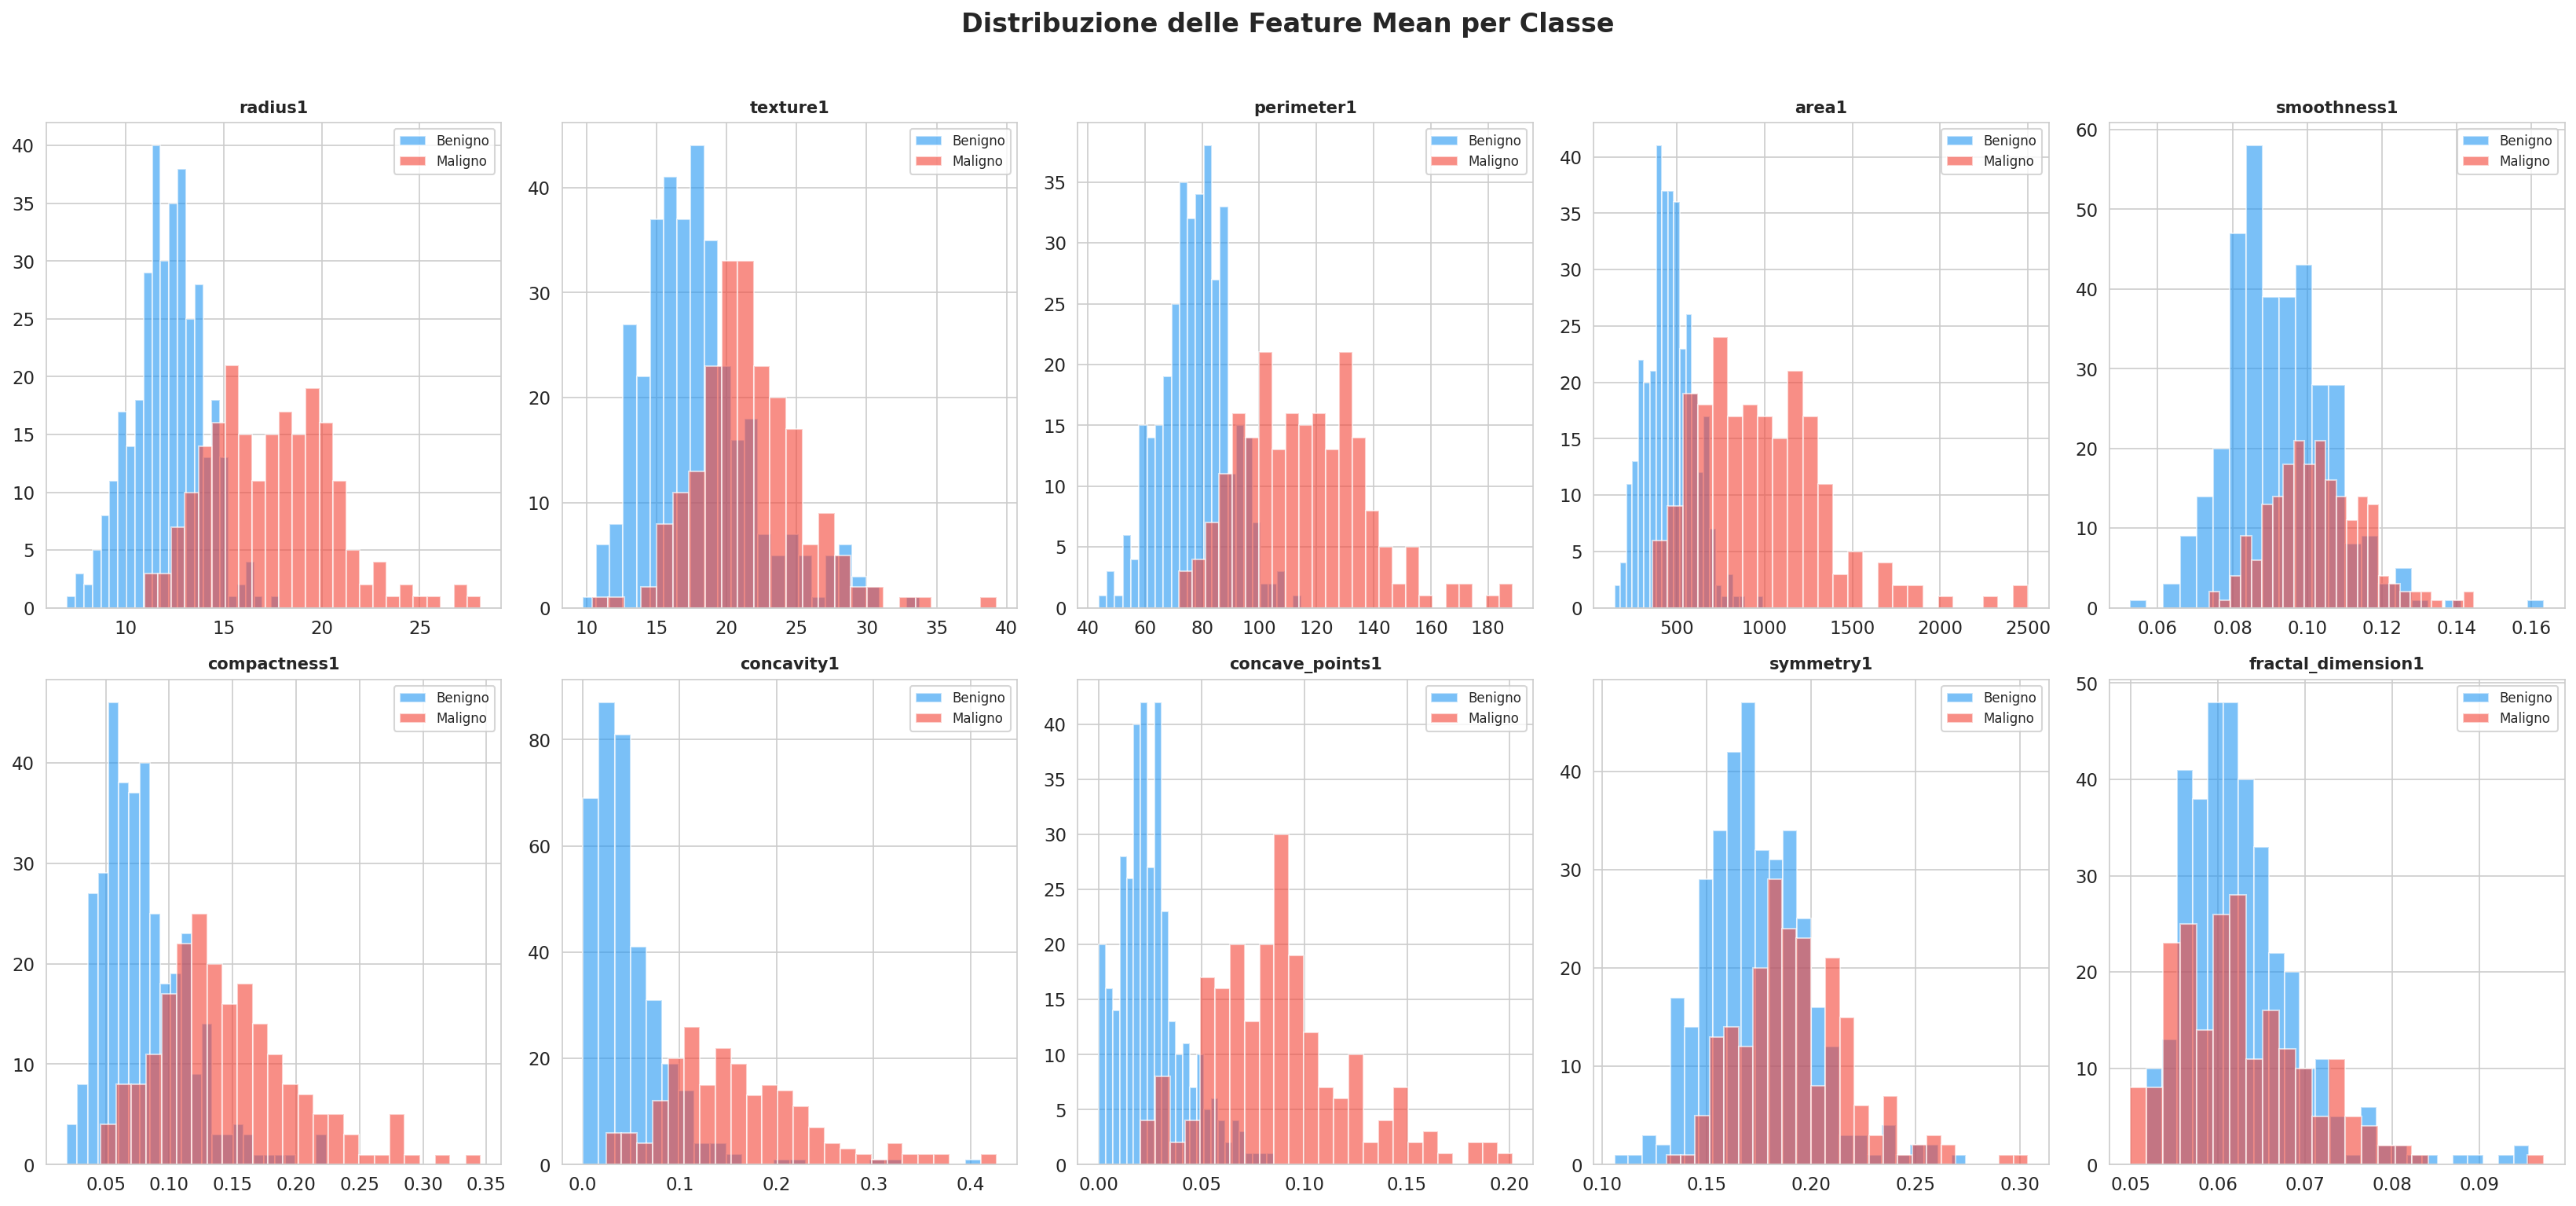

In [182]:
# Istogrammi delle 10 feature mean per classe
# Le colonne 0-9 corrispondono alle feature mean nel dataset UCI
mean_cols = list(X.columns[:10])

fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(mean_cols):
    for cls, color, label in [('B', '#2196F3', 'Benigno'), ('M', '#F44336', 'Maligno')]:
        data = df[df['Diagnosis'] == cls][col]
        axes[i].hist(data, bins=25, alpha=0.6, color=color, label=label, edgecolor='white')
    axes[i].set_title(col, fontweight='bold', fontsize=10)
    axes[i].legend(fontsize=8)

fig.suptitle('Distribuzione delle Feature Mean per Classe', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('02_distribuzioni_feature.png', dpi=300, bbox_inches='tight')
plt.show()

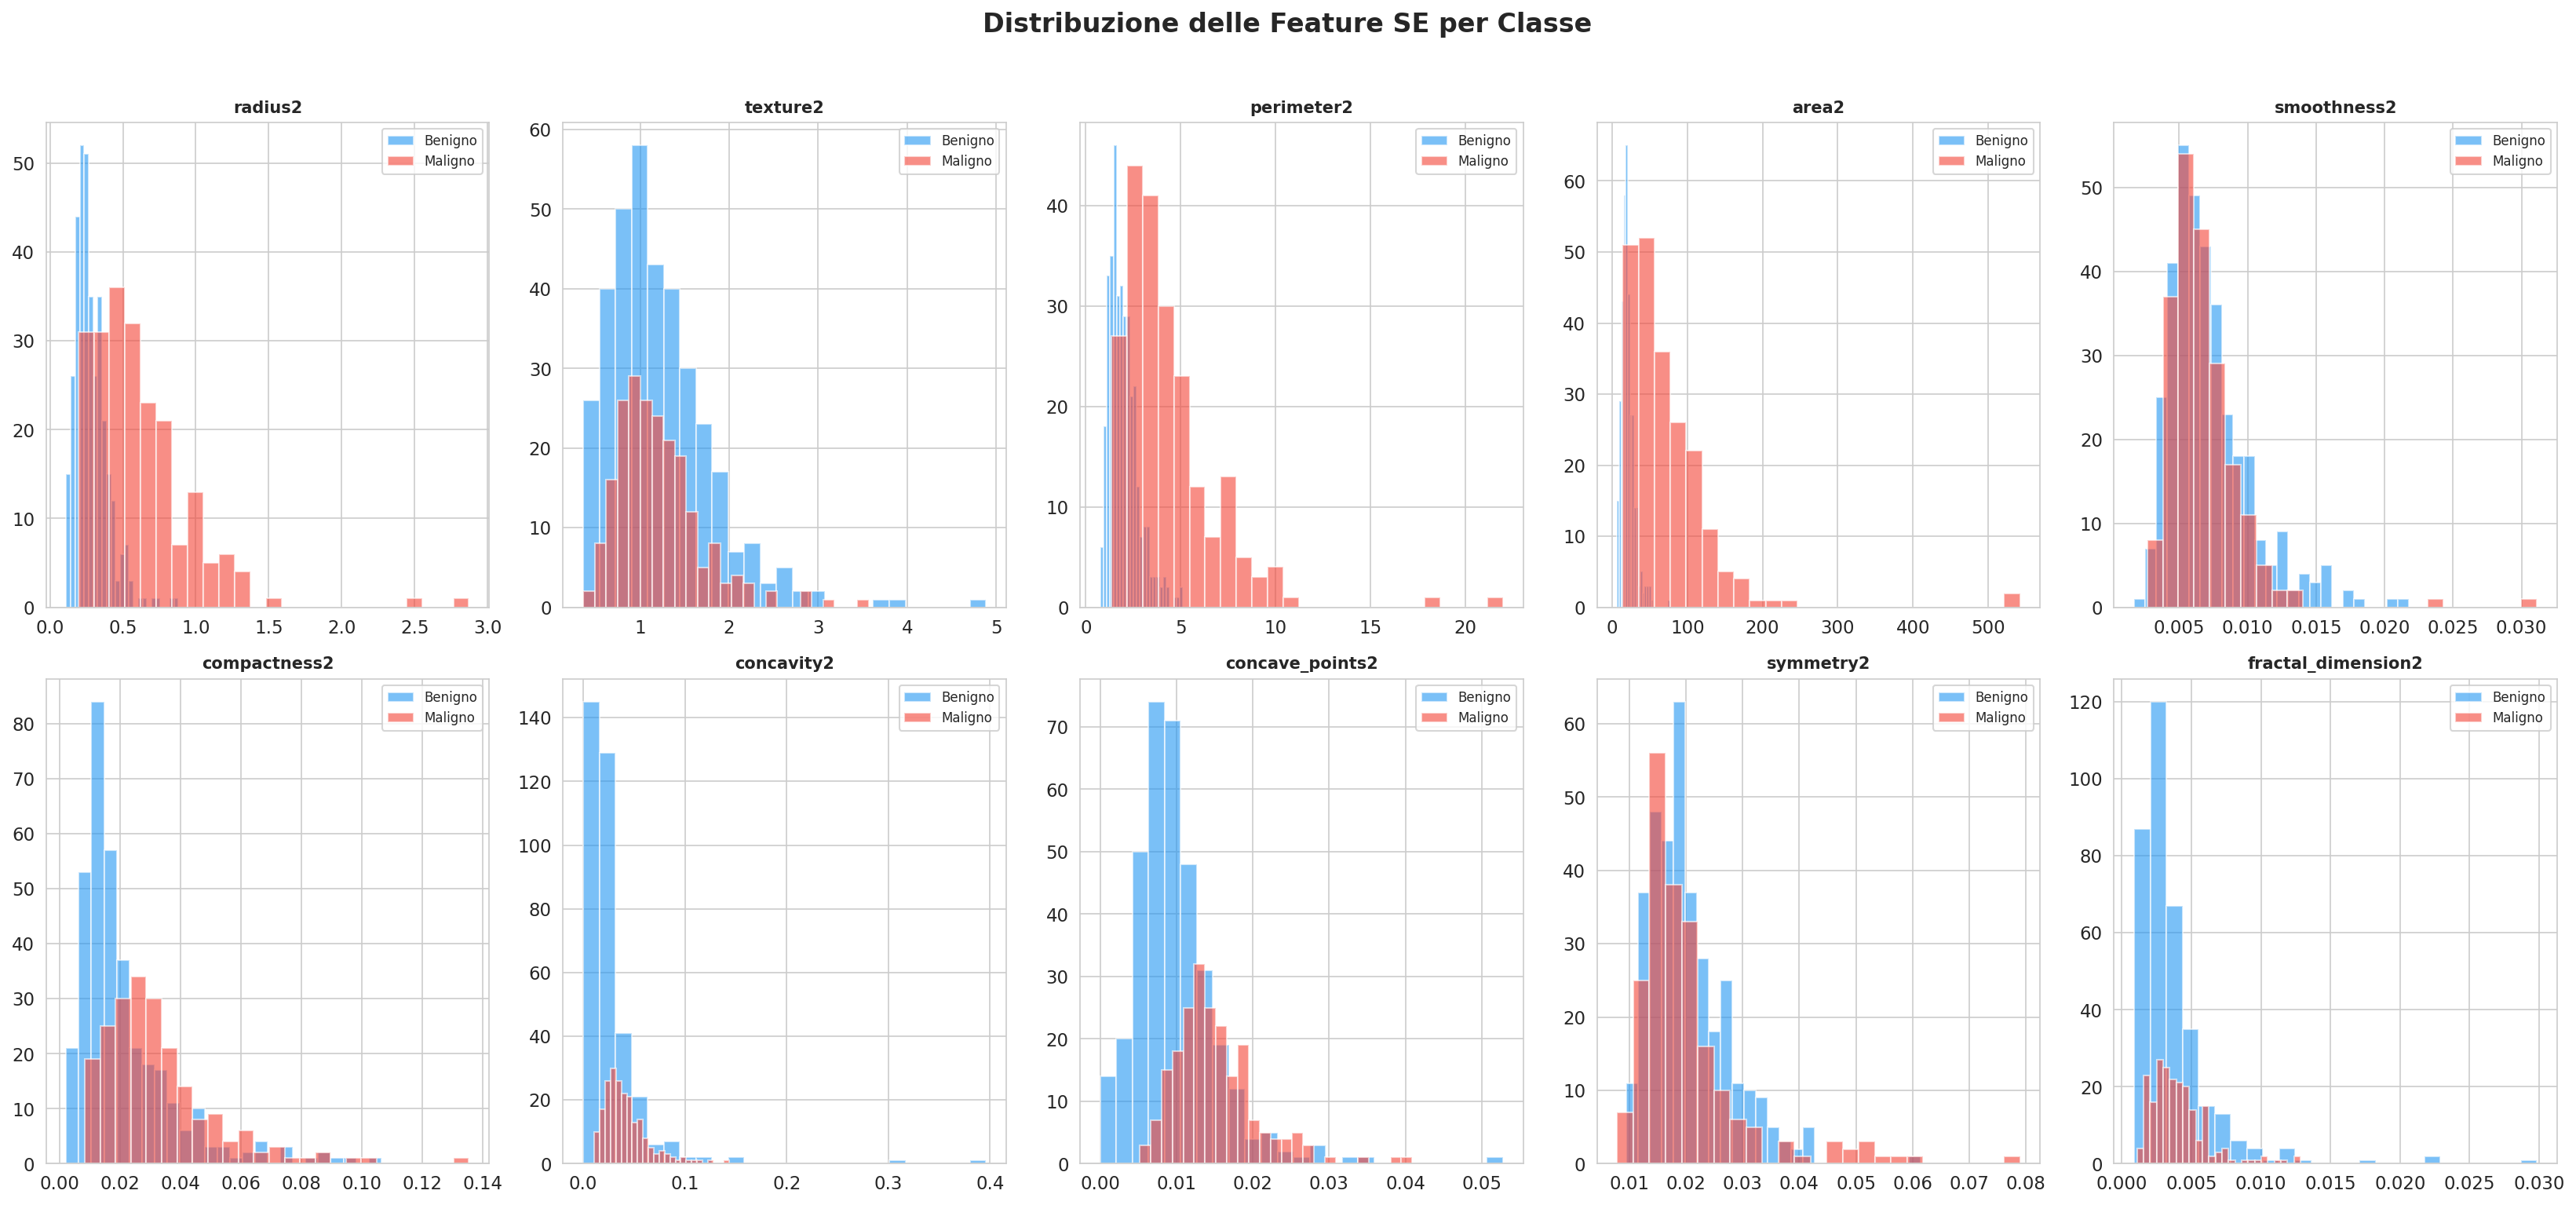

In [183]:
# Istogrammi delle 10 feature SE per classe
se_cols = list(X.columns[10:20])

fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(se_cols):
    for cls, color, label in [('B', '#2196F3', 'Benigno'), ('M', '#F44336', 'Maligno')]:
        data = df[df['Diagnosis'] == cls][col]
        axes[i].hist(data, bins=25, alpha=0.6, color=color, label=label, edgecolor='white')
    axes[i].set_title(col, fontweight='bold', fontsize=10)
    axes[i].legend(fontsize=8)

fig.suptitle('Distribuzione delle Feature SE per Classe', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('02b_distribuzioni_feature_se.png', dpi=300, bbox_inches='tight')
plt.show()

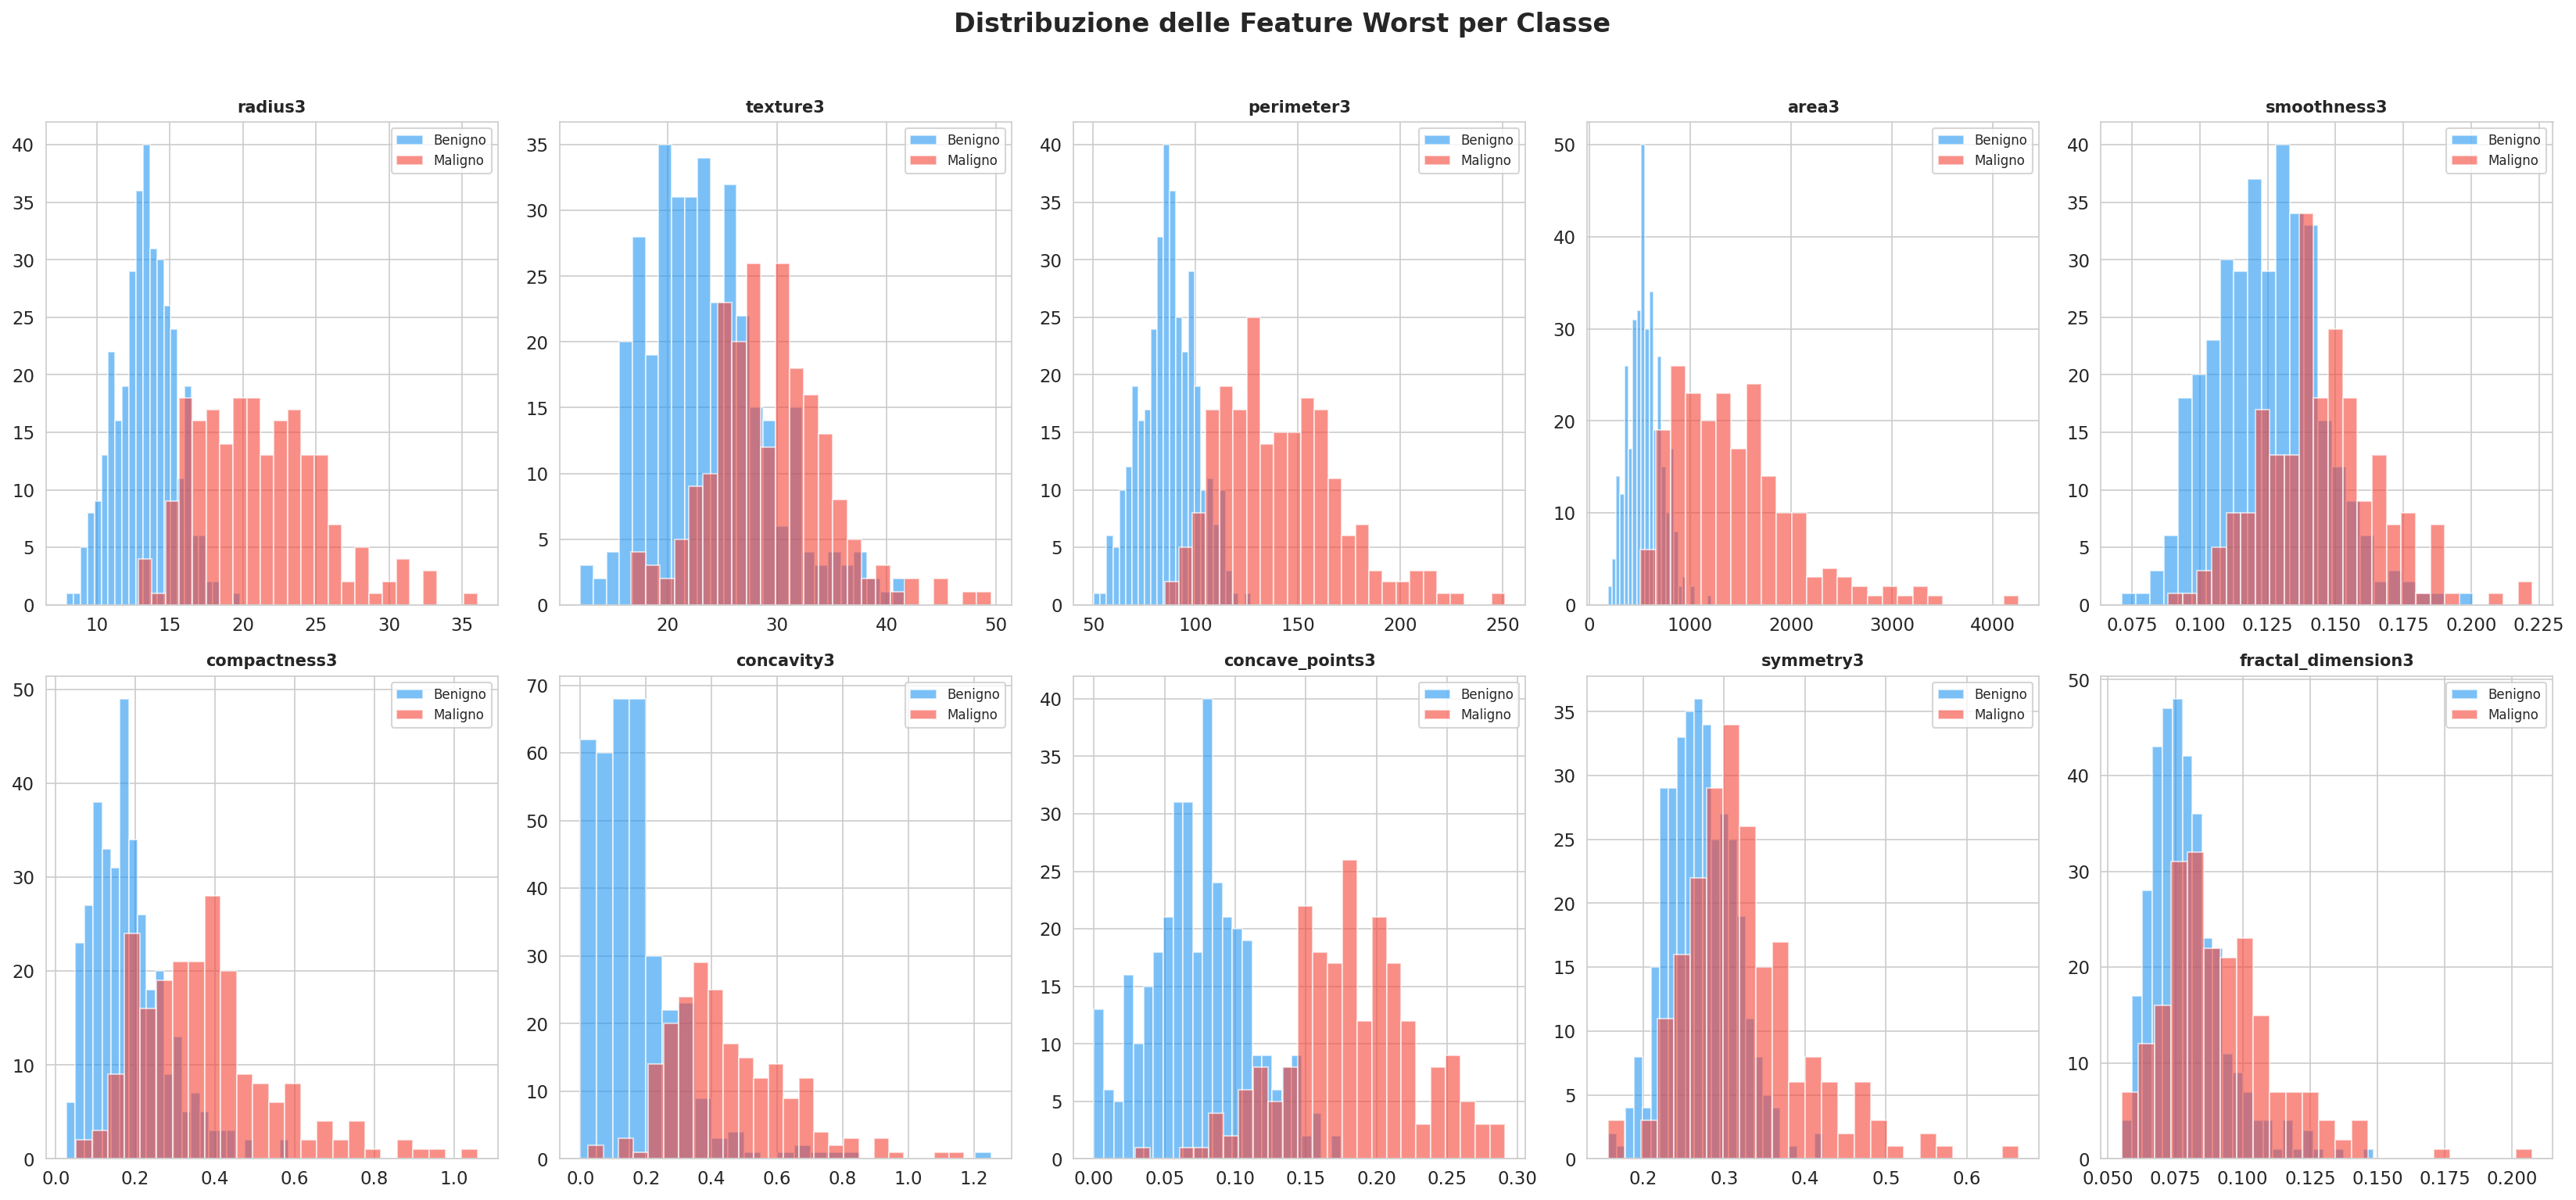

In [184]:
# Istogrammi delle 10 feature Worst per classe
worst_cols = list(X.columns[20:30])

fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(worst_cols):
    for cls, color, label in [('B', '#2196F3', 'Benigno'), ('M', '#F44336', 'Maligno')]:
        data = df[df['Diagnosis'] == cls][col]
        axes[i].hist(data, bins=25, alpha=0.6, color=color, label=label, edgecolor='white')
    axes[i].set_title(col, fontweight='bold', fontsize=10)
    axes[i].legend(fontsize=8)

fig.suptitle('Distribuzione delle Feature Worst per Classe', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('02c_distribuzioni_feature_worst.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-2028376652.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([data_b, data_m], labels=['Benigno', 'Maligno'],
/tmp/ipython-input-2028376652.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([data_b, data_m], labels=['Benigno', 'Maligno'],
/tmp/ipython-input-2028376652.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([data_b, data_m], labels=['Benigno', 'Maligno'],
/tmp/ipython-input-2028376652.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for th

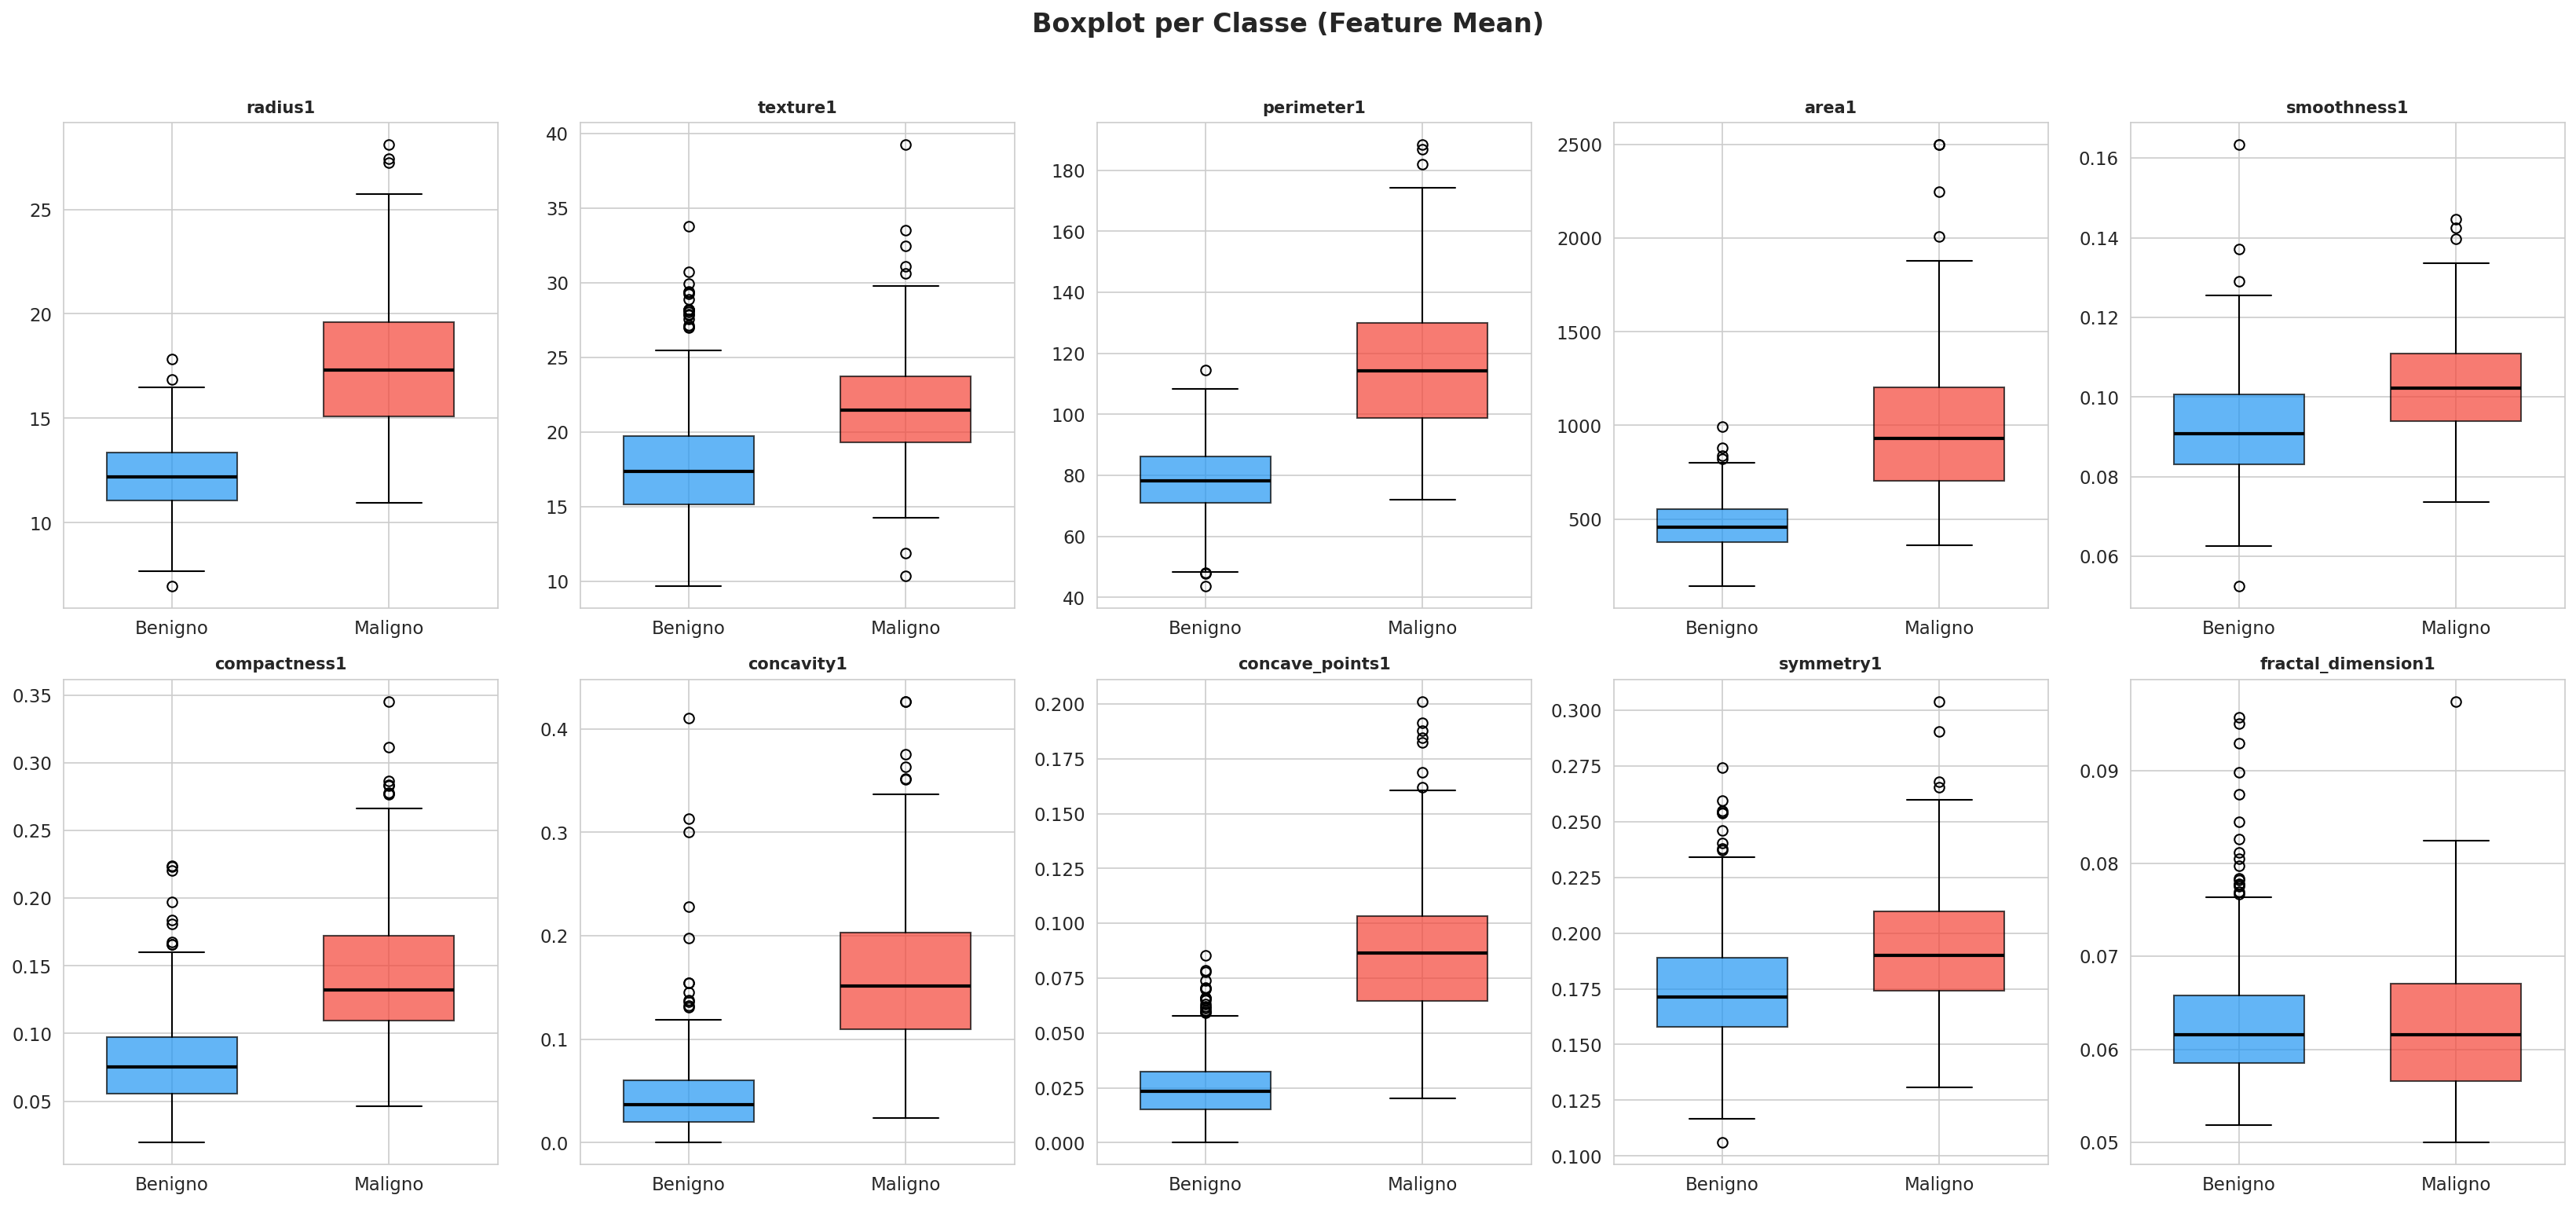

In [185]:
# Boxplot comparativi per classe
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(mean_cols):
    data_b = df[df['Diagnosis'] == 'B'][col]
    data_m = df[df['Diagnosis'] == 'M'][col]
    bp = axes[i].boxplot([data_b, data_m], labels=['Benigno', 'Maligno'],
                         patch_artist=True, widths=0.6,
                         medianprops=dict(color='black', linewidth=2))
    bp['boxes'][0].set_facecolor('#2196F3')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('#F44336')
    bp['boxes'][1].set_alpha(0.7)
    axes[i].set_title(col, fontweight='bold', fontsize=10)

fig.suptitle('Boxplot per Classe (Feature Mean)', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('03_boxplot_feature.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.5 Analisi delle Correlazioni

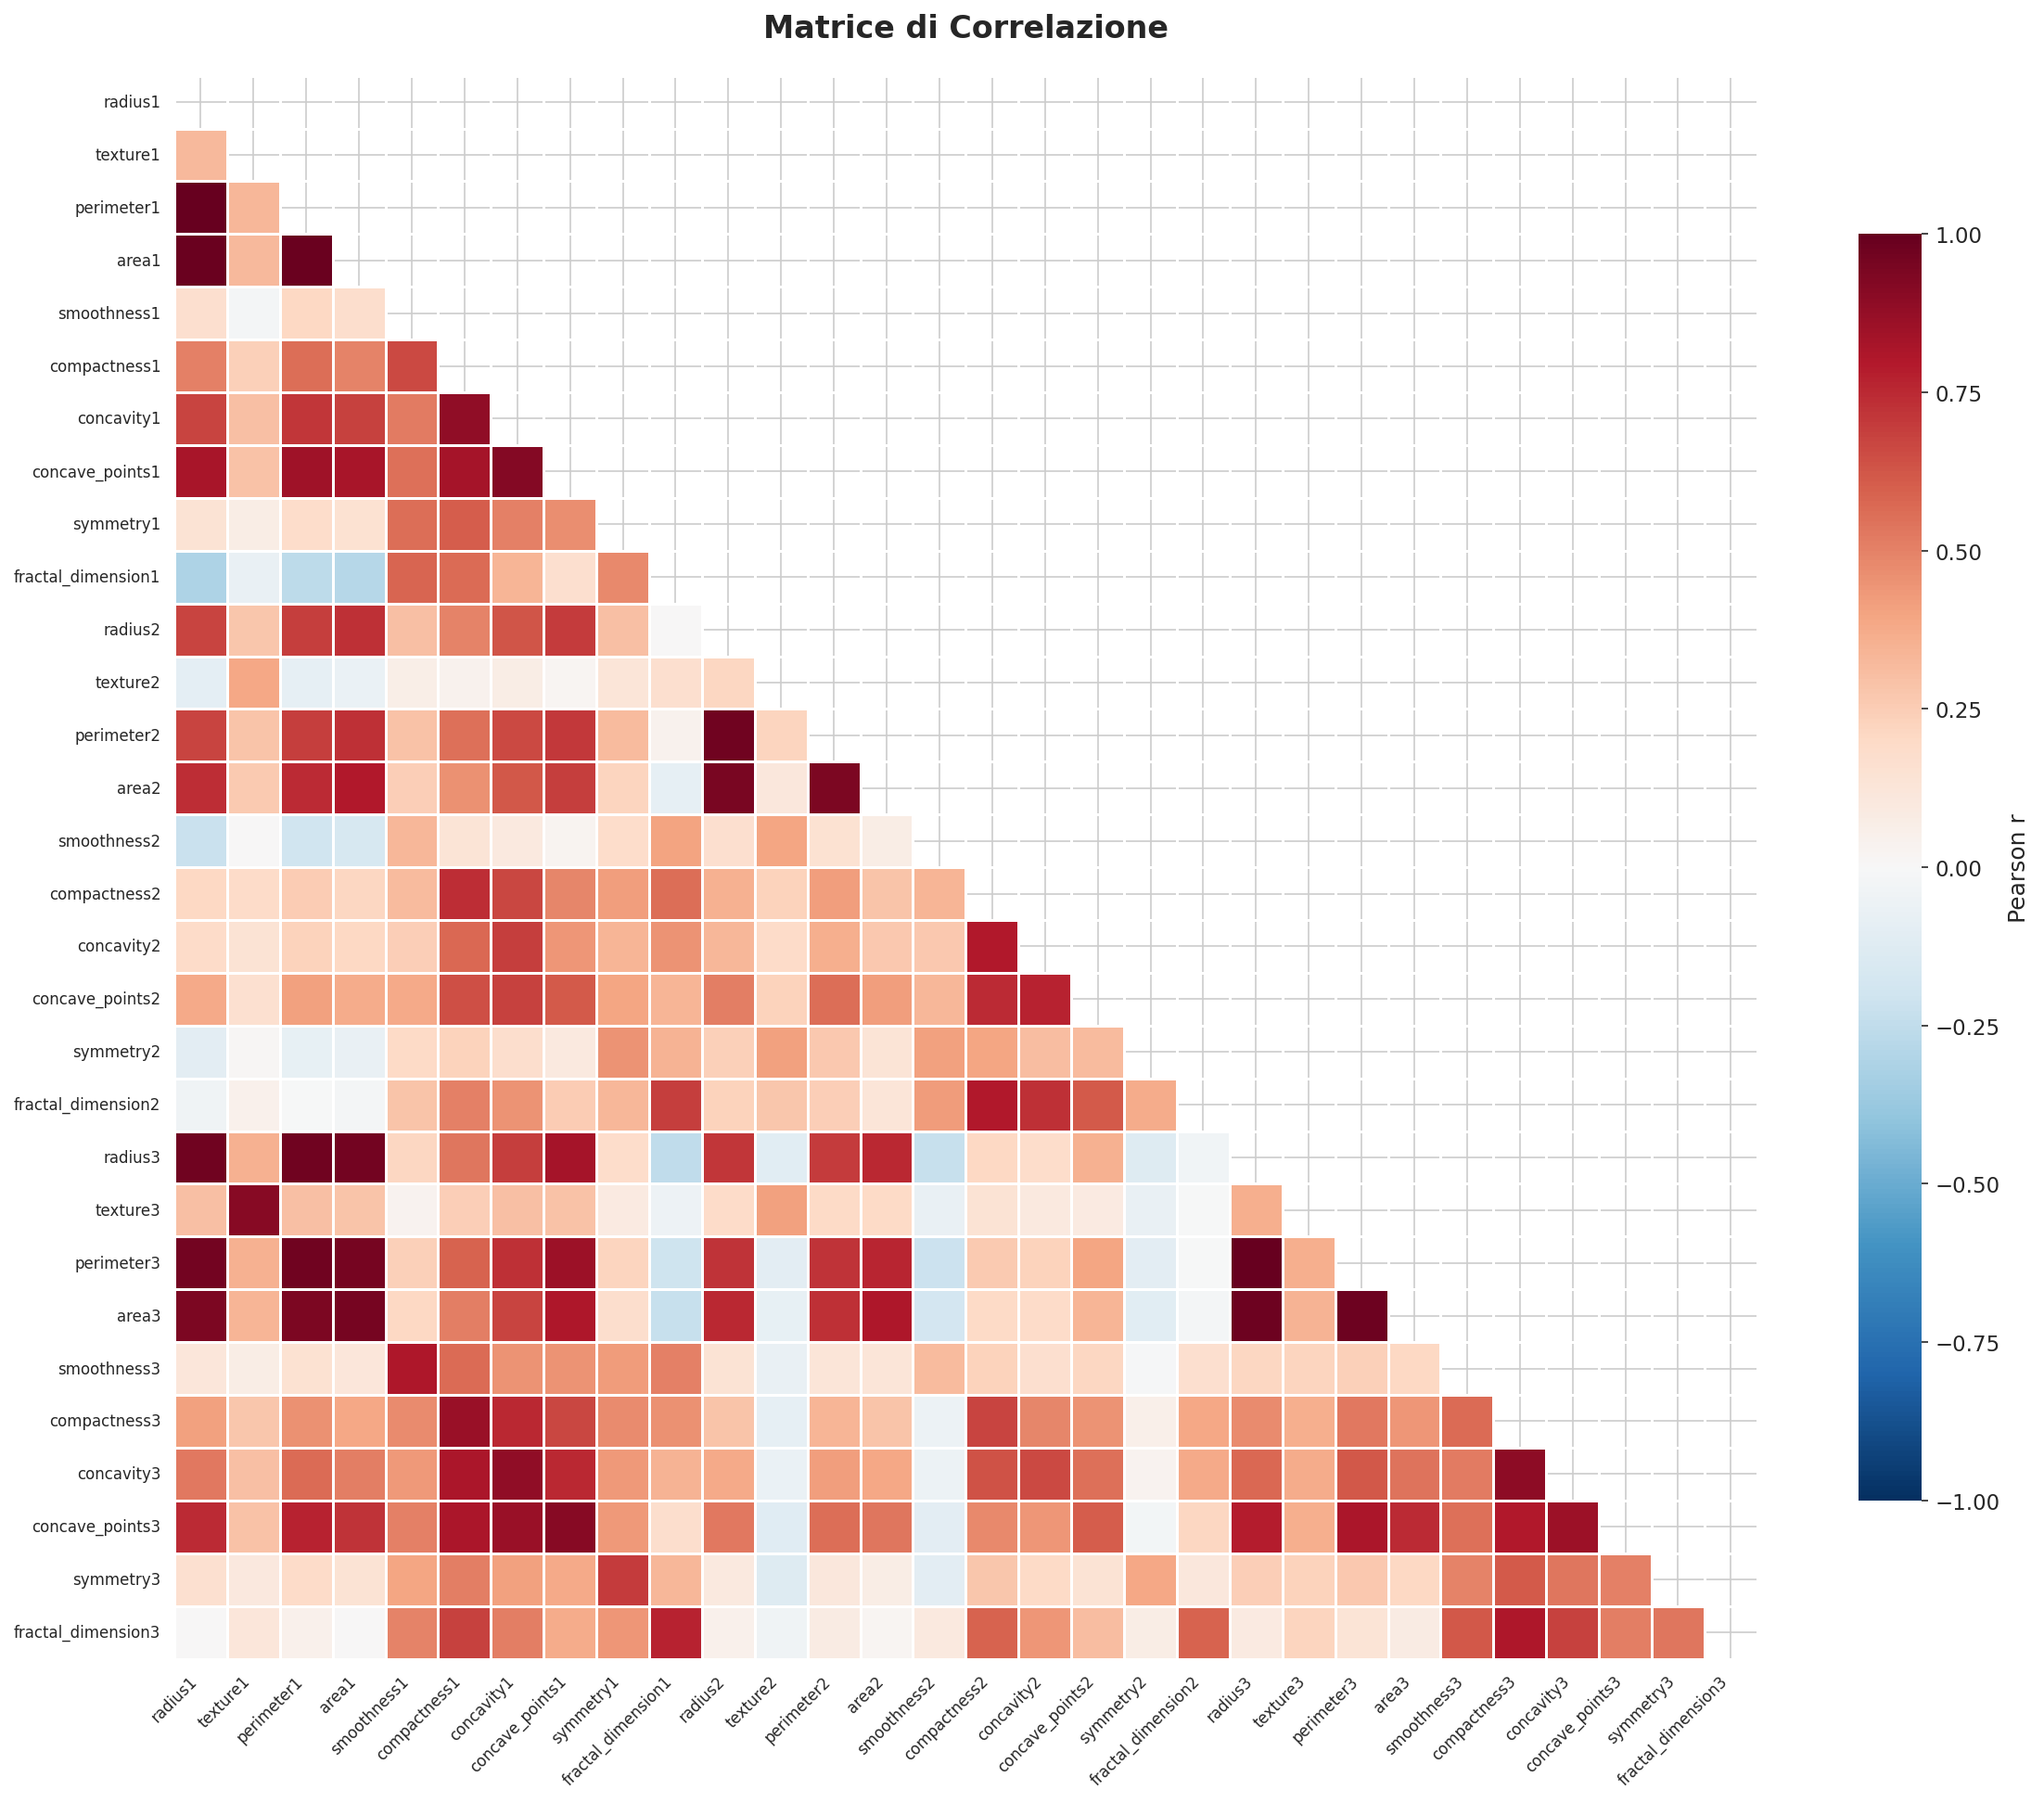

Top 10 coppie piu' correlate:


Feature 1   Feature 2       |r|
0     radius1  perimeter1  0.997855
1     radius3  perimeter3  0.993708
2     radius1       area1  0.987357
3  perimeter1       area1  0.986507
4     radius3       area3  0.984015
5  perimeter3       area3  0.977578
6     radius2  perimeter2  0.972794
7  perimeter1  perimeter3  0.970387
8     radius1     radius3  0.969539
9  perimeter1     radius3  0.969476

In [186]:
corr_matrix = X.corr()

fig, ax = plt.subplots(figsize=(16, 13))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8, 'label': 'Pearson r'})
ax.set_title('Matrice di Correlazione', fontweight='bold', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('04_matrice_correlazione.png', dpi=300, bbox_inches='tight')
plt.show()

# Top coppie correlate
upper = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
pairs = []
for col in upper.columns:
    for idx in upper.index:
        val = upper.loc[idx, col]
        if pd.notna(val):
            pairs.append((idx, col, abs(val)))

pairs_df = pd.DataFrame(pairs, columns=['Feature 1', 'Feature 2', '|r|'])
pairs_df = pairs_df.sort_values('|r|', ascending=False)
print('Top 10 coppie piu\' correlate:')
display(pairs_df.head(10).reset_index(drop=True))

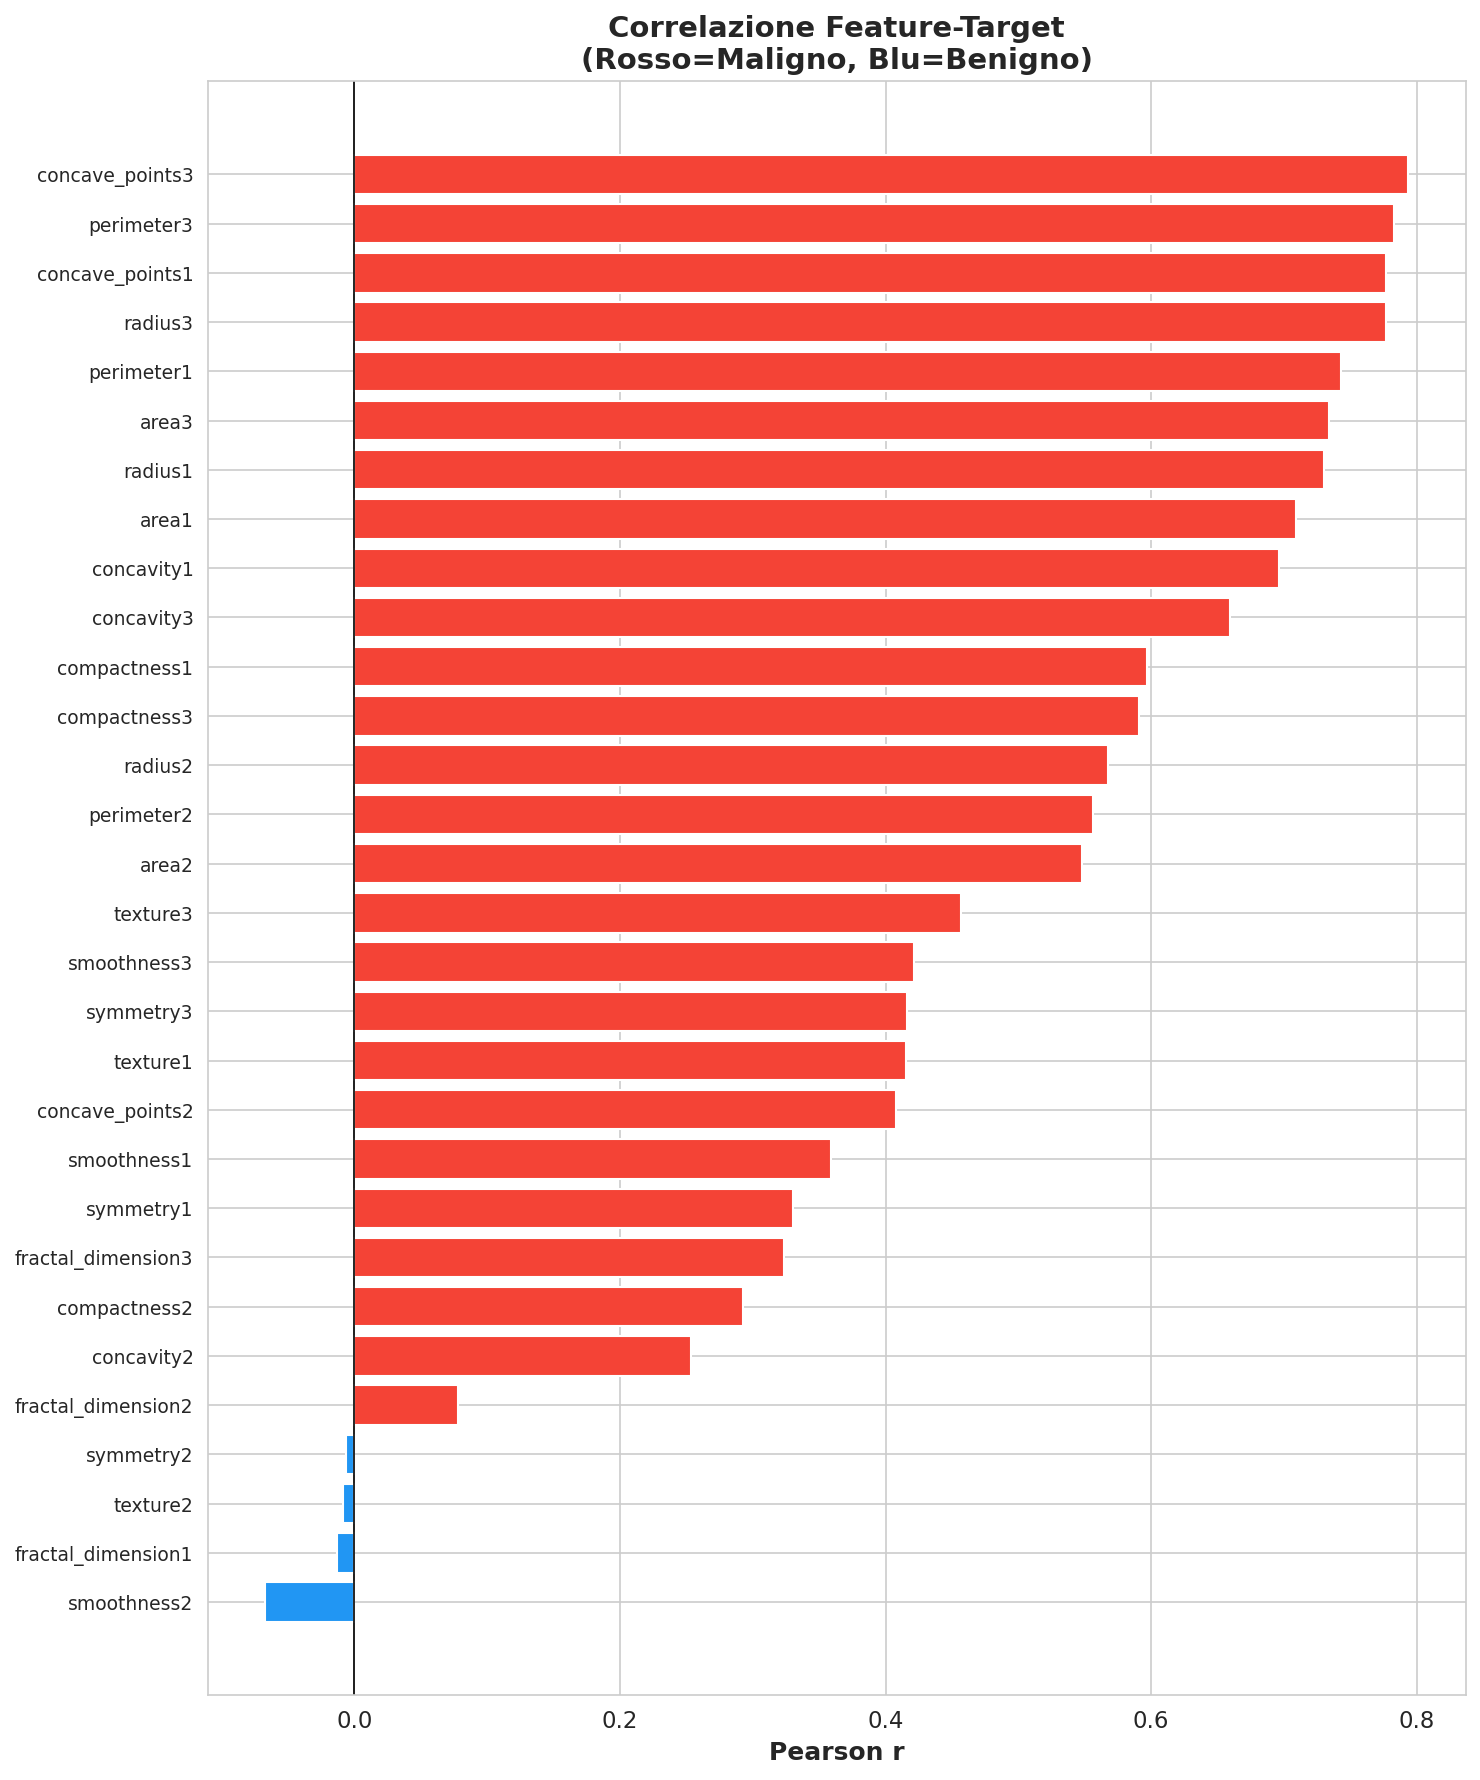

Top 5 feature correlate con diagnosi maligna:
  concave_points3: 0.7936
  perimeter3: 0.7829
  concave_points1: 0.7766
  radius3: 0.7765
  perimeter1: 0.7426


In [187]:
# Correlazione con il target
corr_target = X.corrwith(pd.Series(y, index=X.index)).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 12))
colors_bar = ['#F44336' if v > 0 else '#2196F3' for v in corr_target.values]
ax.barh(range(len(corr_target)), corr_target.values, color=colors_bar)
ax.set_yticks(range(len(corr_target)))
ax.set_yticklabels(corr_target.index, fontsize=9)
ax.set_xlabel('Pearson r', fontweight='bold')
ax.set_title('Correlazione Feature-Target\n(Rosso=Maligno, Blu=Benigno)', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('05_correlazione_target.png', dpi=300, bbox_inches='tight')
plt.show()

print('Top 5 feature correlate con diagnosi maligna:')
for feat, val in corr_target.head(5).items():
    print(f'  {feat}: {val:.4f}')

### 4.6 Identificazione Outlier

In [188]:
def count_outliers_iqr(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return ((series < Q1 - k * IQR) | (series > Q3 + k * IQR)).sum()

outlier_counts = X.apply(count_outliers_iqr)
outlier_pct = (outlier_counts / len(X) * 100).round(2)

outlier_df = pd.DataFrame({
    'Feature': outlier_counts.index,
    'N. Outlier': outlier_counts.values,
    '% Outlier': outlier_pct.values
}).sort_values('N. Outlier', ascending=False)

display(outlier_df.head(10).reset_index(drop=True))

print('\nNota: gli outlier NON vengono rimossi.')
print('In ambito medico i valori estremi possono essere clinicamente significativi.')

Feature  N. Outlier  % Outlier
0               area2          65      11.42
1             radius2          38       6.68
2          perimeter2          38       6.68
3               area3          35       6.15
4         smoothness2          30       5.27
5  fractal_dimension2          28       4.92
6        compactness2          28       4.92
7           symmetry2          27       4.75
8               area1          25       4.39
9  fractal_dimension3          24       4.22


Nota: gli outlier NON vengono rimossi.
In ambito medico i valori estremi possono essere clinicamente significativi.


### 4.7 Pairplot Feature Principali

Top 5 feature per pairplot: ['concave_points3', 'perimeter3', 'concave_points1', 'radius3', 'perimeter1']


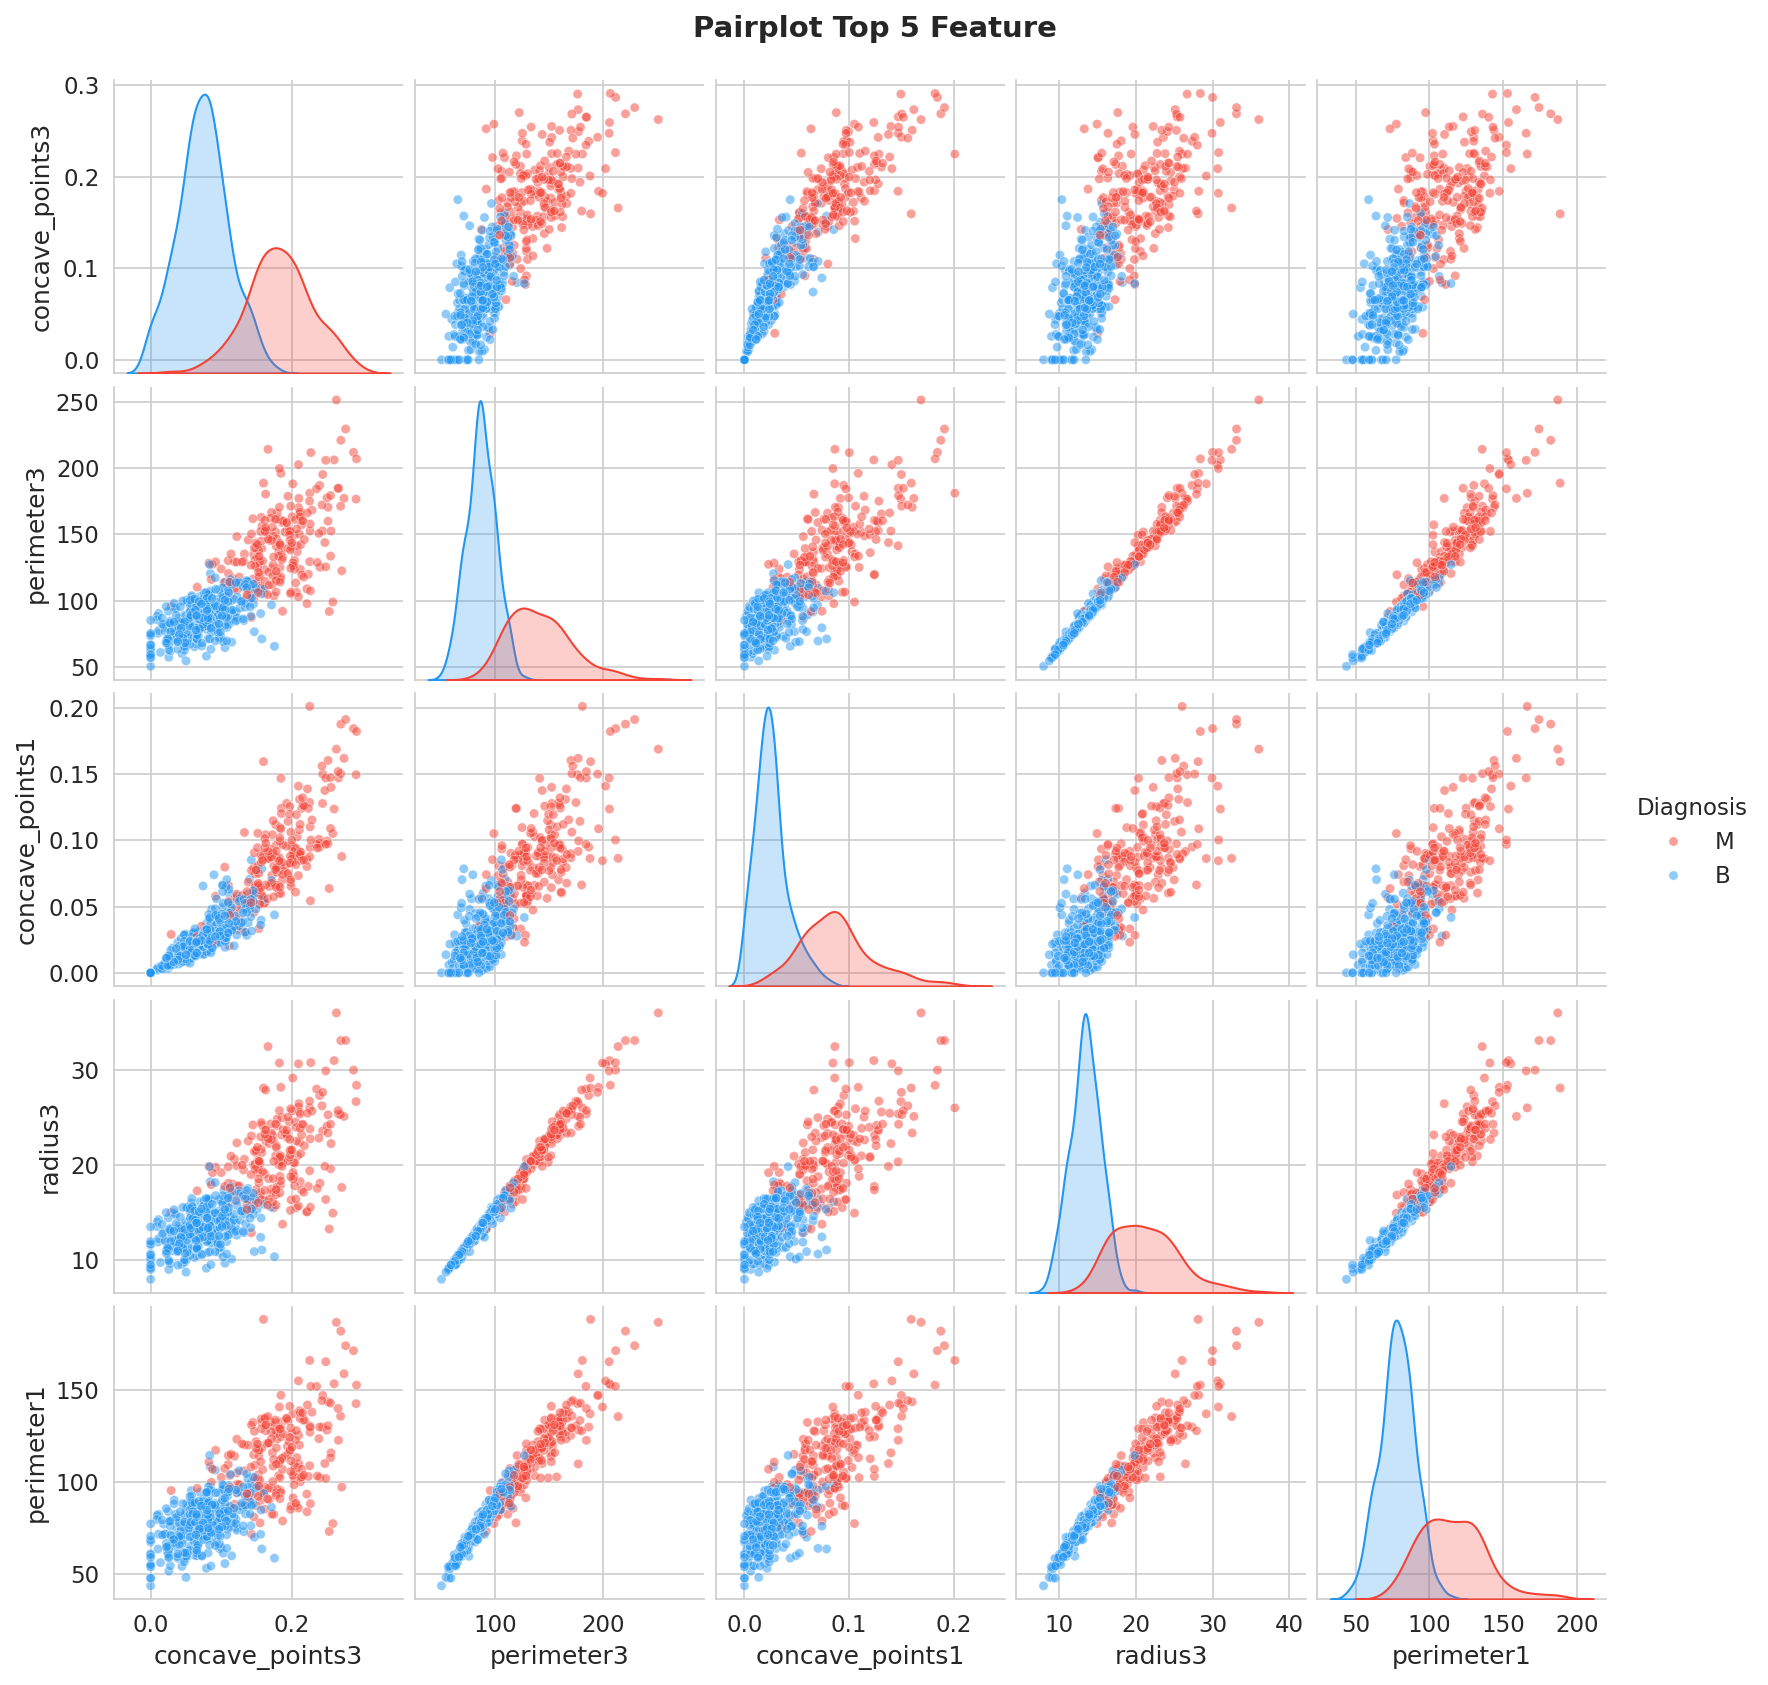

In [189]:
top5 = corr_target.abs().sort_values(ascending=False).head(5).index.tolist()
print(f'Top 5 feature per pairplot: {top5}')

g = sns.pairplot(df[top5 + ['Diagnosis']], hue='Diagnosis',
                 palette={'B': '#2196F3', 'M': '#F44336'},
                 diag_kind='kde', plot_kws={'alpha': 0.5, 's': 20}, height=2.2)
g.figure.suptitle('Pairplot Top 5 Feature', fontweight='bold', fontsize=14, y=1.02)
plt.savefig('06_pairplot.png', dpi=200, bbox_inches='tight')
plt.show()

### 4.8 Analisi PCA — Varianza Spiegata e Scelta delle Componenti

L'alta correlazione tra feature (sezione 4.5) suggerisce ridondanza informativa. La PCA permette di quantificare quante componenti sono effettivamente necessarie per rappresentare i dati.

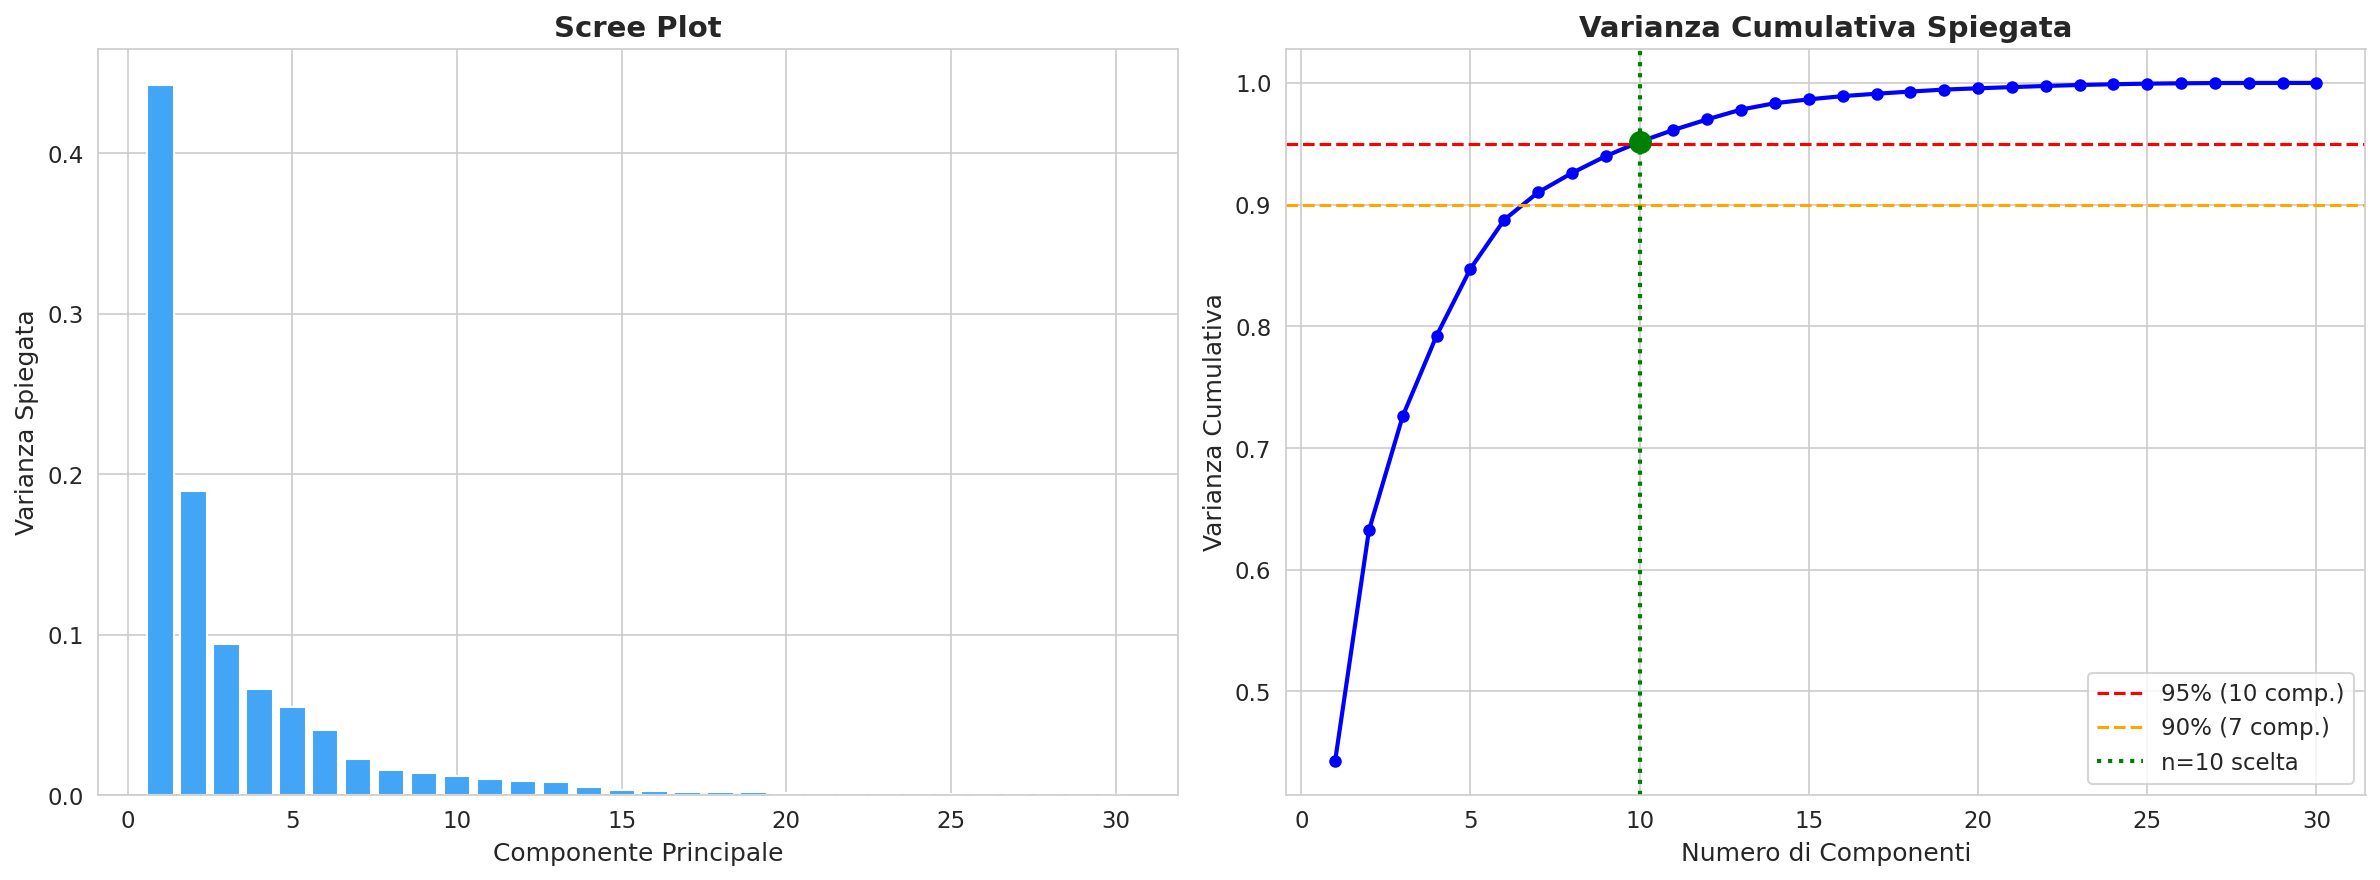

Componenti per 90% varianza: 7
Componenti per 95% varianza: 10
Varianza con 10 componenti:  95.16%
Varianza con 2 componenti:   63.24%

Varianza spiegata per componente:
  PC 1: 44.27%  (cum: 44.27%)  ############################################
  PC 2: 18.97%  (cum: 63.24%)  ##################
  PC 3:  9.39%  (cum: 72.64%)  #########
  PC 4:  6.60%  (cum: 79.24%)  ######
  PC 5:  5.50%  (cum: 84.73%)  #####
  PC 6:  4.02%  (cum: 88.76%)  ####
  PC 7:  2.25%  (cum: 91.01%)  ##
  PC 8:  1.59%  (cum: 92.60%)  #
  PC 9:  1.39%  (cum: 93.99%)  #
  PC10:  1.17%  (cum: 95.16%)  #
  PC11:  0.98%  (cum: 96.14%)  
  PC12:  0.87%  (cum: 97.01%)  
  PC13:  0.80%  (cum: 97.81%)  
  PC14:  0.52%  (cum: 98.34%)  
  PC15:  0.31%  (cum: 98.65%)  

==> Scelta: n_components=10
    Le 30 feature originali derivano da 10 misure base (mean/SE/worst).
    Con 10 componenti si cattura 95.2% della varianza,
    eliminando la ridondanza tra feature correlate (r>0.95 per radius/perimeter/area)
    e riducendo l

In [190]:
# PCA esplorativa: quante componenti servono per spiegare il 95% della varianza?
# Nota: lo scaling e' necessario perche' PCA e' sensibile alla scala delle feature.
scaler_eda = StandardScaler()
X_scaled_eda = scaler_eda.fit_transform(X)

pca_eda = PCA()
pca_eda.fit(X_scaled_eda)
cumvar_eda = np.cumsum(pca_eda.explained_variance_ratio_)

n_95_eda = np.argmax(cumvar_eda >= 0.95) + 1
n_90_eda = np.argmax(cumvar_eda >= 0.90) + 1

# --- Grafico: Scree Plot + Varianza Cumulativa ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(range(1, 31), pca_eda.explained_variance_ratio_,
            color='#42A5F5', edgecolor='white')
axes[0].set_xlabel('Componente Principale')
axes[0].set_ylabel('Varianza Spiegata')
axes[0].set_title('Scree Plot', fontweight='bold')

axes[1].plot(range(1, 31), cumvar_eda, 'bo-', linewidth=2, markersize=5)
axes[1].axhline(y=0.95, color='r', linestyle='--', label=f'95% ({n_95_eda} comp.)')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label=f'90% ({n_90_eda} comp.)')
axes[1].axvline(x=10, color='green', linestyle=':', linewidth=2, label=f'n=10 scelta')
axes[1].scatter([10], [cumvar_eda[9]], color='green', s=100, zorder=5)
axes[1].set_xlabel('Numero di Componenti')
axes[1].set_ylabel('Varianza Cumulativa')
axes[1].set_title('Varianza Cumulativa Spiegata', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('06b_pca_varianza_eda.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Tabella riassuntiva ---
print(f'Componenti per 90% varianza: {n_90_eda}')
print(f'Componenti per 95% varianza: {n_95_eda}')
print(f'Varianza con 10 componenti:  {cumvar_eda[9]*100:.2f}%')
print(f'Varianza con 2 componenti:   {cumvar_eda[1]*100:.2f}%')
print()
print('Varianza spiegata per componente:')
for i in range(min(15, len(pca_eda.explained_variance_ratio_))):
    bar = '#' * int(pca_eda.explained_variance_ratio_[i] * 100)
    print(f'  PC{i+1:2d}: {pca_eda.explained_variance_ratio_[i]*100:5.2f}%  '
          f'(cum: {cumvar_eda[i]*100:5.2f}%)  {bar}')

print()
print(f'==> Scelta: n_components=10')
print(f'    Le 30 feature originali derivano da 10 misure base (mean/SE/worst).')
print(f'    Con 10 componenti si cattura {cumvar_eda[9]*100:.1f}% della varianza,')
print(f'    eliminando la ridondanza tra feature correlate (r>0.95 per radius/perimeter/area)')
print(f'    e riducendo la dimensionalita\' da 30 a 10, coerentemente con le 10 misure base.')

### 4.9 Sintesi EDA

**Osservazioni chiave che guidano la scelta dei modelli:**

1. **Tutte le feature sono numeriche continue** -> nessun bisogno di OneHotEncoder/ColumnTransformer
2. **Class imbalance moderato (63/37)** -> necessario `class_weight='balanced'`
3. **Alta correlazione tra feature** (radius/perimeter/area, r>0.95) -> ridondanza informativa
4. **Buona separabilita' visiva** tra classi nei boxplot e pairplot -> i modelli dovrebbero performare bene
5. **Nessun missing value** -> SimpleImputer incluso solo per robustezza
6. **Outlier presenti** ma non rimossi (significato clinico)
7. **PCA**: 10 componenti principali catturano la quasi totalita' della varianza utile, coerentemente con le 10 misure morfologiche base -> scelta `n_components=10` per la riduzione dimensionale nelle pipeline

---
## 5. Description and Rationale for the ML Models Chosen

### 5.1 SVM (Soft Margin, Kernel RBF)

**Rationale:**

La documentazione scikit-learn afferma che SVM e' *"effective in high dimensional spaces"* e *"still effective in cases where number of dimensions is greater than the number of samples"*. Il nostro dataset (30 feature, 569 campioni) rientra in questo scenario.

- **Soft margin** (parametro C): gestisce l'overlap tra classi e gli outlier non rimossi
- **Kernel RBF**: mappa i dati in uno spazio a dimensionalita' superiore dove le classi diventano linearmente separabili (kernel trick)
- **Parametro gamma**: controlla il raggio di influenza di ogni support vector
- Richiede **StandardScaler** (documentazione: *"SVM works best with scaled data"*) -> inserito nella Pipeline per evitare data leakage

### 5.2 Decision Tree (CART)

**Rationale:**

La documentazione scikit-learn elenca come vantaggi: *"Simple to understand and to interpret"* e *"Uses a white box model"*. In ambito medico l'interpretabilita' e' fondamentale.

- **CART** usa l'impurita' di Gini per gli split binari (a differenza di ID3 che usa entropy)
- Gestisce nativamente feature continue senza bisogno di scaling
- **Limiti noti** (dalla documentazione): *"Decision trees can be unstable"* e *"can create over-complex trees that do not generalize"* -> controlliamo con `max_depth` e **Cost Complexity Pruning** (`ccp_alpha`)
- **Pruning (ccp_alpha)**: la documentazione scikit-learn descrive il *Minimal Cost-Complexity Pruning* come tecnica per ridurre la complessita' dell'albero. Valori crescenti di `ccp_alpha` producono alberi piu' semplici, riducendo l'overfitting. Il valore ottimale viene selezionato via GridSearchCV
- La documentazione avverte anche: *"Decision tree learners create biased trees if some classes dominate"* -> useremo `class_weight='balanced'`
- Fornisce `feature_importances_` nativamente

### 5.3 K-Means (Unsupervised)

**Rationale:**

Analisi complementare per verificare se i dati hanno una **struttura naturale a 2 cluster** senza usare le etichette.
- Validazione con **Silhouette Score** (qualita' interna) e **Adjusted Rand Index** (confronto con classi reali)
- Conferma/smentisce l'ipotesi di separabilita' formulata nell'EDA

### 5.4 Scelte di Preprocessing

| Scelta | Motivazione |
|--------|-------------|
| **PCA(n_components=10)** | Riduzione dimensionale da 30 a 10 componenti principali (vedi analisi in sezione 4.8). Le 30 feature derivano da 10 misure base (mean/SE/worst): 10 PC riassumono l'informazione eliminando la ridondanza tra feature correlate. Inserita nella Pipeline per evitare data leakage |
| Pipeline per SVM | `SimpleImputer` + `StandardScaler` + `PCA` + `SVC` — lo scaler e' necessario sia per PCA (sensibile alla scala) che per SVM |
| Pipeline per CART | `SimpleImputer` + `StandardScaler` + `PCA` + `DecisionTreeClassifier` — lo scaler e' necessario per PCA. Nota: con PCA i threshold dell'albero sono sulle componenti principali, non sulle feature originali |
| **Pruning (ccp_alpha)** | Cost Complexity Pruning per il Decision Tree, ottimizzato via GridSearchCV. Controlla la complessita' dell'albero e previene l'overfitting |
| SimpleImputer(median) | Nessun missing nel dataset, ma incluso per robustezza in produzione |
| class_weight='balanced' | Imbalance moderato (63/37), pesi inversamente proporzionali alla frequenza |
| Niente ColumnTransformer | Tutte le feature sono numeriche — aggiungerlo sarebbe codice morto |

---
## 6. Experimental Campaign

### 6.1 Split Stratificato

In [191]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f'Training: {X_train.shape[0]} campioni ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'Test:     {X_test.shape[0]} campioni ({X_test.shape[0]/len(X)*100:.0f}%)')
print(f'\nDistribuzione classi:')
print(f'  Training - B: {(y_train==0).sum()}, M: {(y_train==1).sum()}')
print(f'  Test     - B: {(y_test==0).sum()}, M: {(y_test==1).sum()}')

Training: 455 campioni (80%)
Test:     114 campioni (20%)

Distribuzione classi:
  Training - B: 285, M: 170
  Test     - B: 72, M: 42


In [192]:
# --- SVM Pipeline ---
# La documentazione scikit-learn raccomanda esplicitamente:
#   make_pipeline(StandardScaler(), SVC())
# PCA(n_components=10) riduce le 30 feature a 10 componenti principali
# prima della classificazione (scelta giustificata nell'EDA, sezione 4.8).
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10, random_state=RANDOM_STATE)),
    ('classifier', SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,   # Necessario per predict_proba e ROC-AUC
                             # Nota: usa Platt scaling (CV interna 5-fold),
                             # rallenta il fit ma e' necessario per ROC-AUC
        random_state=RANDOM_STATE
    ))
])

# --- Decision Tree Pipeline ---
# Con PCA il Decision Tree opera sulle componenti principali: i threshold
# dell'albero non saranno piu' nelle unita' originali, ma la riduzione
# dimensionale migliora la generalizzazione e riduce la ridondanza.
# Lo StandardScaler e' necessario perche' PCA e' sensibile alla scala.
# Il pruning viene controllato via ccp_alpha nel GridSearchCV.
dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10, random_state=RANDOM_STATE)),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

pipelines = {
    'SVM (RBF)': svm_pipeline,
    'Decision Tree (CART)': dt_pipeline,
}

print('Pipeline definite:')
for name, pipe in pipelines.items():
    steps = ' -> '.join([s[0] for s in pipe.steps])
    print(f'  {name}: {steps}')

Pipeline definite:
  SVM (RBF): imputer -> scaler -> pca -> classifier
  Decision Tree (CART): imputer -> scaler -> pca -> classifier


### 6.3 Cross-Validation (10-Fold Stratificata)

Usiamo `cross_validate` (non `cross_val_score`) per calcolare 5 metriche in una sola chiamata, evitando di ri-fittare il modello per ogni metrica.

In [193]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}

for name, pipe in pipelines.items():
    print(f'Valutando: {name}...')
    cv_res = cross_validate(
        pipe, X_train, y_train,
        cv=cv,
        scoring=scoring_metrics,
        n_jobs=-1
    )
    cv_results[name] = cv_res

    for metric in scoring_metrics:
        key = f'test_{metric}'
        mean = cv_res[key].mean()
        std = cv_res[key].std()
        print(f'  {metric:<12s}: {mean:.4f} +/- {std:.4f}')
    print()

# Tabella riassuntiva
cv_summary = []
for name in pipelines:
    row = {'Modello': name}
    for metric in scoring_metrics:
        key = f'test_{metric}'
        m = cv_results[name][key].mean()
        s = cv_results[name][key].std()
        row[metric.upper()] = f'{m:.4f} +/- {s:.4f}'
    cv_summary.append(row)

display(pd.DataFrame(cv_summary))

Valutando: SVM (RBF)...
  accuracy    : 0.9648 +/- 0.0298
  precision   : 0.9536 +/- 0.0334
  recall      : 0.9529 +/- 0.0686
  f1          : 0.9520 +/- 0.0425
  roc_auc     : 0.9933 +/- 0.0097

Valutando: Decision Tree (CART)...
  accuracy    : 0.9252 +/- 0.0330
  precision   : 0.9020 +/- 0.0504
  recall      : 0.9000 +/- 0.0647
  f1          : 0.8995 +/- 0.0453
  roc_auc     : 0.9201 +/- 0.0376



Modello           ACCURACY          PRECISION  \
0             SVM (RBF)  0.9648 +/- 0.0298  0.9536 +/- 0.0334   
1  Decision Tree (CART)  0.9252 +/- 0.0330  0.9020 +/- 0.0504   

              RECALL                 F1            ROC_AUC  
0  0.9529 +/- 0.0686  0.9520 +/- 0.0425  0.9933 +/- 0.0097  
1  0.9000 +/- 0.0647  0.8995 +/- 0.0453  0.9201 +/- 0.0376

/tmp/ipython-input-4140513613.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(cv_data, labels=list(pipelines.keys()), patch_artist=True, widths=0.5,


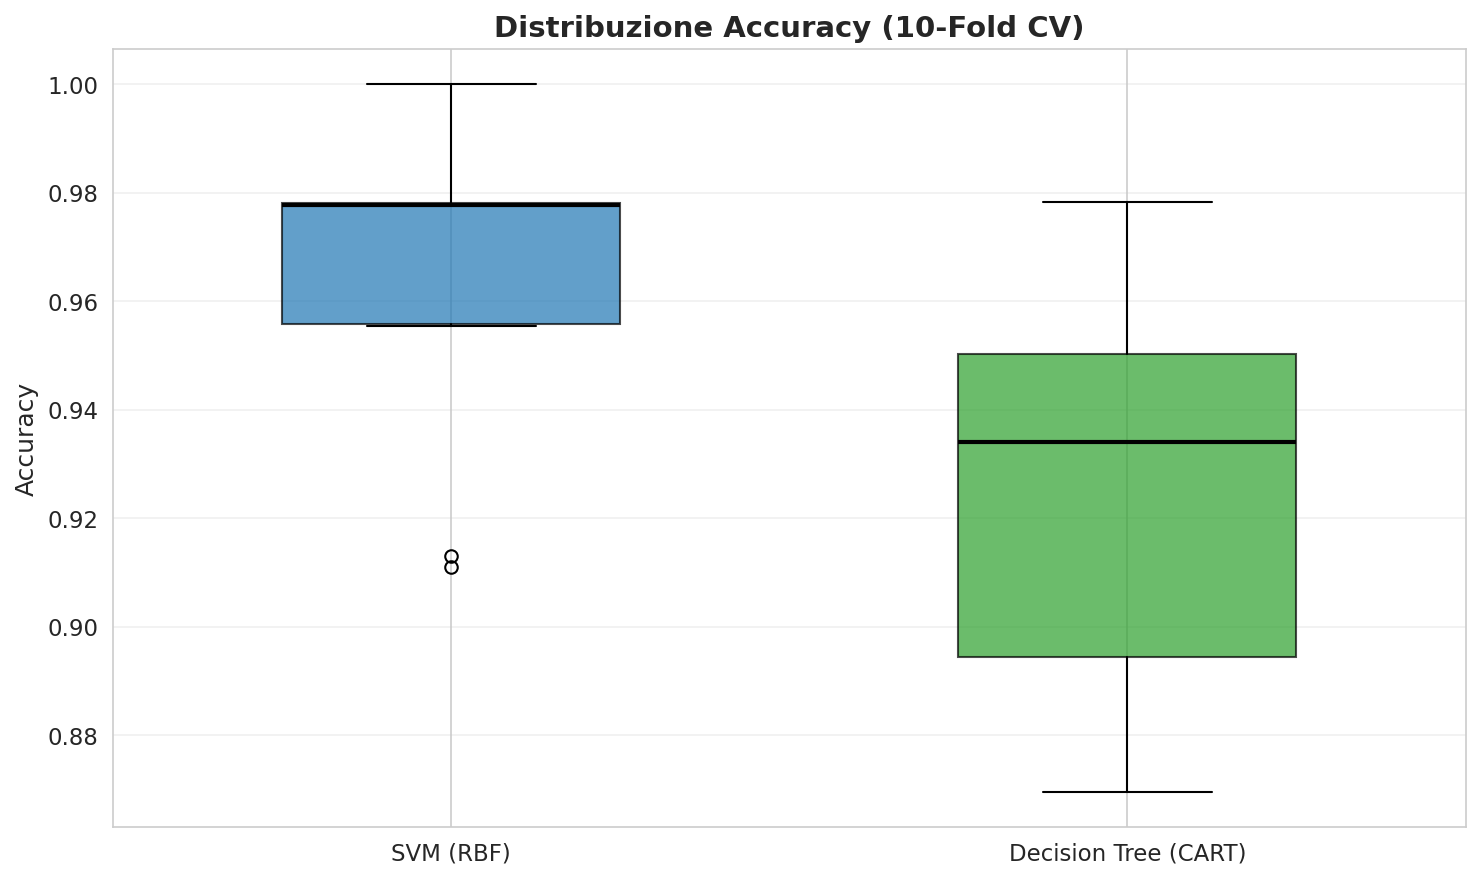

In [194]:
# Boxplot CV accuracy
fig, ax = plt.subplots(figsize=(10, 6))
cv_data = [cv_results[name]['test_accuracy'] for name in pipelines]
bp = ax.boxplot(cv_data, labels=list(pipelines.keys()), patch_artist=True, widths=0.5,
                medianprops=dict(color='black', linewidth=2))
for patch, color in zip(bp['boxes'], ['#1f77b4', '#2ca02c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Accuracy')
ax.set_title('Distribuzione Accuracy (10-Fold CV)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('07_cv_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.4 Hyperparameter Tuning (GridSearchCV)

La documentazione scikit-learn raccomanda per SVM:
> *"It is recommended to use GridSearchCV with C and gamma values spaced exponentially far apart to identify optimal settings."*

I parametri usano la sintassi `step__param` della Pipeline. La CV interna usa **10-fold stratificata**, coerente con la cross-validation della sezione 6.3.

In [195]:
# --- Griglie di iperparametri ---

# SVM: la documentazione consiglia C e gamma spaziati esponenzialmente
svm_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.01, 0.001],
    'classifier__kernel': ['rbf'],
}

# CART: max_depth e' il parametro piu' importante per controllare overfitting.
# ccp_alpha controlla il Cost Complexity Pruning (post-pruning):
#   - 0.0 = nessun pruning
#   - valori crescenti = pruning piu' aggressivo (albero piu' semplice)
# Ref: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
dt_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.02],
}

param_grids = {
    'SVM (RBF)': svm_param_grid,
    'Decision Tree (CART)': dt_param_grid,
}

# --- Esecuzione GridSearchCV ---
# 10-fold coerente con la cross_validate della sezione precedente
cv_tuning = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

best_models = {}
tuning_results = []

for name, pipe in pipelines.items():
    n_comb = 1
    for vals in param_grids[name].values():
        n_comb *= len(vals)
    print(f'{name}: {n_comb} combinazioni x 10 fold')

    grid = GridSearchCV(
        pipe,
        param_grid=param_grids[name],
        cv=cv_tuning,
        scoring='f1',     # F1 perche' dominio medico
        n_jobs=-1,
        refit=True
    )
    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_

    print(f'  Migliori parametri: {grid.best_params_}')
    print(f'  Miglior F1 (CV):    {grid.best_score_:.4f}')

    tuning_results.append({
        'Modello': name,
        'Miglior F1 (CV)': f'{grid.best_score_:.4f}',
        'Parametri': str(grid.best_params_)
    })
    print()

display(pd.DataFrame(tuning_results))

SVM (RBF): 16 combinazioni x 10 fold
  Migliori parametri: {'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
  Miglior F1 (CV):    0.9705

Decision Tree (CART): 600 combinazioni x 10 fold
  Migliori parametri: {'classifier__ccp_alpha': 0.0, 'classifier__criterion': 'entropy', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
  Miglior F1 (CV):    0.9213



Modello Miglior F1 (CV)  \
0             SVM (RBF)          0.9705   
1  Decision Tree (CART)          0.9213   

                                           Parametri  
0  {'classifier__C': 100, 'classifier__gamma': 0....  
1  {'classifier__ccp_alpha': 0.0, 'classifier__cr...

### 6.5 Valutazione sul Test Set

In [196]:
predictions = {}
test_results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    predictions[name] = {'y_pred': y_pred, 'y_prob': y_prob}

    metrics = {
        'Modello': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
    }
    test_results.append(metrics)

    print(f'{name}:')
    for k, v in metrics.items():
        if k != 'Modello':
            print(f'  {k:<12s}: {v:.4f}')
    print()

results_df = pd.DataFrame(test_results)
display(results_df.round(4))

SVM (RBF):
  Accuracy    : 0.9825
  Precision   : 1.0000
  Recall      : 0.9524
  F1-Score    : 0.9756
  ROC-AUC     : 0.9974

Decision Tree (CART):
  Accuracy    : 0.9474
  Precision   : 0.9286
  Recall      : 0.9286
  F1-Score    : 0.9286
  ROC-AUC     : 0.9555



Modello  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0             SVM (RBF)    0.9825     1.0000  0.9524    0.9756   0.9974
1  Decision Tree (CART)    0.9474     0.9286  0.9286    0.9286   0.9555

---
## 7. Analysis of the Results

### 7.1 Confusion Matrices

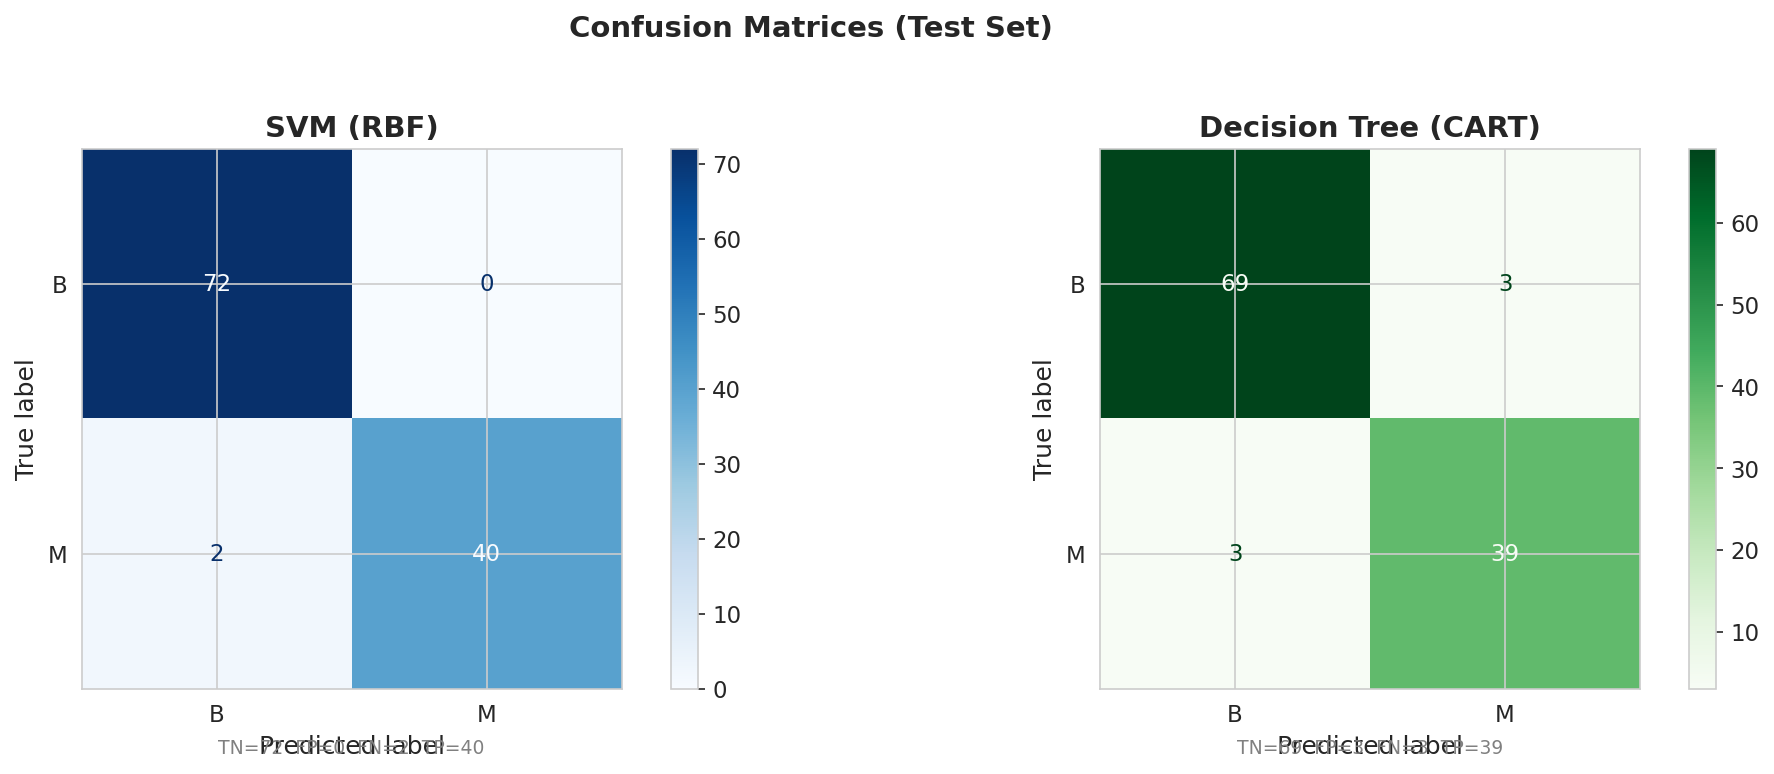

Nota clinica:
  FN (Falsi Negativi) = maligno classificato benigno -> ERRORE CRITICO
  FP (Falsi Positivi) = benigno classificato maligno -> esami aggiuntivi


In [197]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cmaps = ['Blues', 'Greens']

for i, (name, preds) in enumerate(predictions.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_test, preds['y_pred'],
        display_labels=le.classes_,
        cmap=cmaps[i],
        ax=axes[i]
    )
    axes[i].set_title(f'{name}', fontweight='bold')

    cm = confusion_matrix(y_test, preds['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    axes[i].text(0.5, -0.12, f'TN={tn}  FP={fp}  FN={fn}  TP={tp}',
                transform=axes[i].transAxes, ha='center', fontsize=9, color='gray')

fig.suptitle('Confusion Matrices (Test Set)', fontweight='bold', fontsize=14, y=1.03)
plt.tight_layout()
plt.savefig('08_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print('Nota clinica:')
print('  FN (Falsi Negativi) = maligno classificato benigno -> ERRORE CRITICO')
print('  FP (Falsi Positivi) = benigno classificato maligno -> esami aggiuntivi')

In [198]:
# Classification report per ogni modello
for name, preds in predictions.items():
    print(f'--- {name} ---')
    print(classification_report(
        y_test, preds['y_pred'],
        target_names=[f'{c} ({i})' for i, c in enumerate(le.classes_)]
    ))

--- SVM (RBF) ---
              precision    recall  f1-score   support

       B (0)       0.97      1.00      0.99        72
       M (1)       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

--- Decision Tree (CART) ---
              precision    recall  f1-score   support

       B (0)       0.96      0.96      0.96        72
       M (1)       0.93      0.93      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



### 7.2 Curve ROC

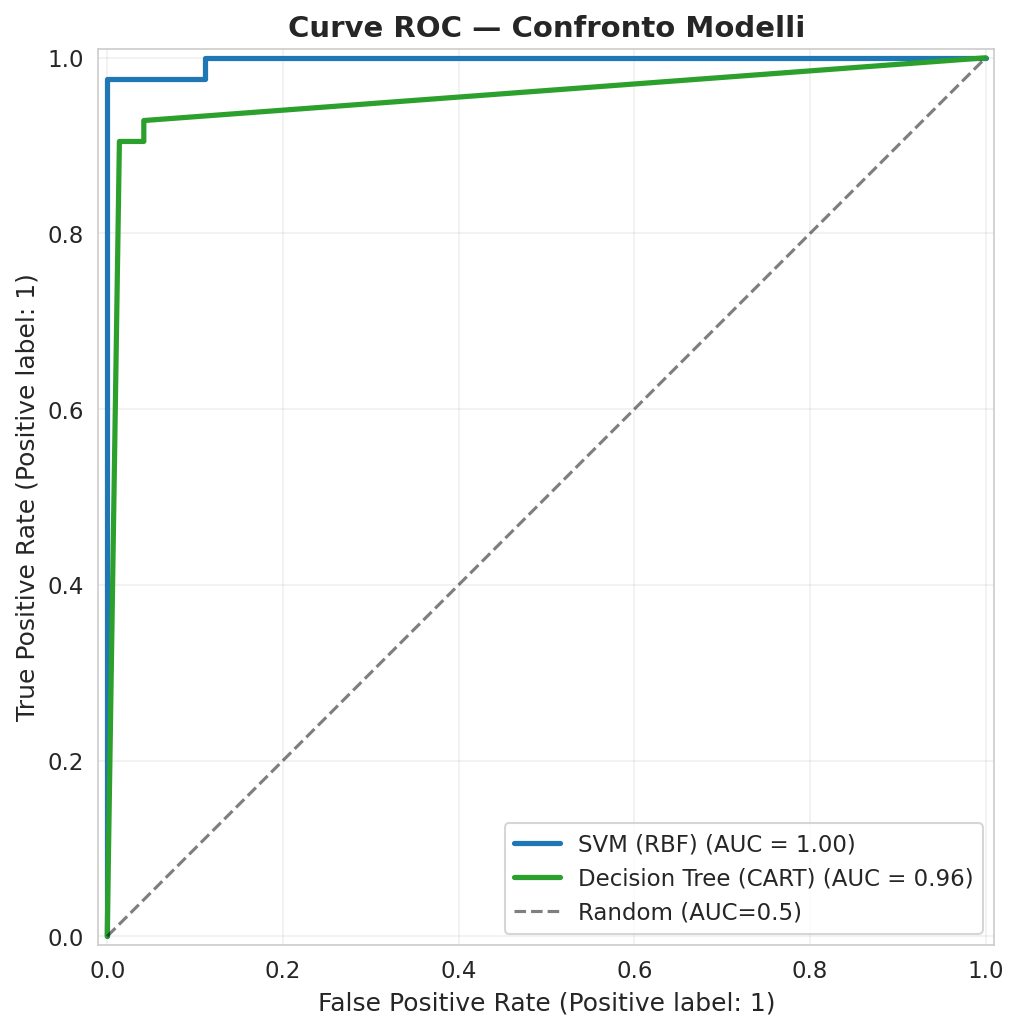

In [199]:
fig, ax = plt.subplots(figsize=(9, 7))
colors_roc = ['#1f77b4', '#2ca02c']

for i, (name, preds) in enumerate(predictions.items()):
    RocCurveDisplay.from_predictions(
        y_test, preds['y_prob'],
        name=name,
        color=colors_roc[i],
        linewidth=2.5,
        ax=ax
    )

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC=0.5)')
ax.set_title('Curve ROC — Confronto Modelli', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('09_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.3 Feature Importance

Pruning: ccp_alpha=0.0, profondita' effettiva=7

Feature Importance — Decision Tree (CART) su Componenti Principali:
   1. PC1        0.7436
   2. PC2        0.0975
   3. PC5        0.0616
   4. PC4        0.0376
   5. PC3        0.0285
   6. PC9        0.0251
   7. PC10       0.0062
   8. PC8        0.0000
   9. PC7        0.0000
  10. PC6        0.0000


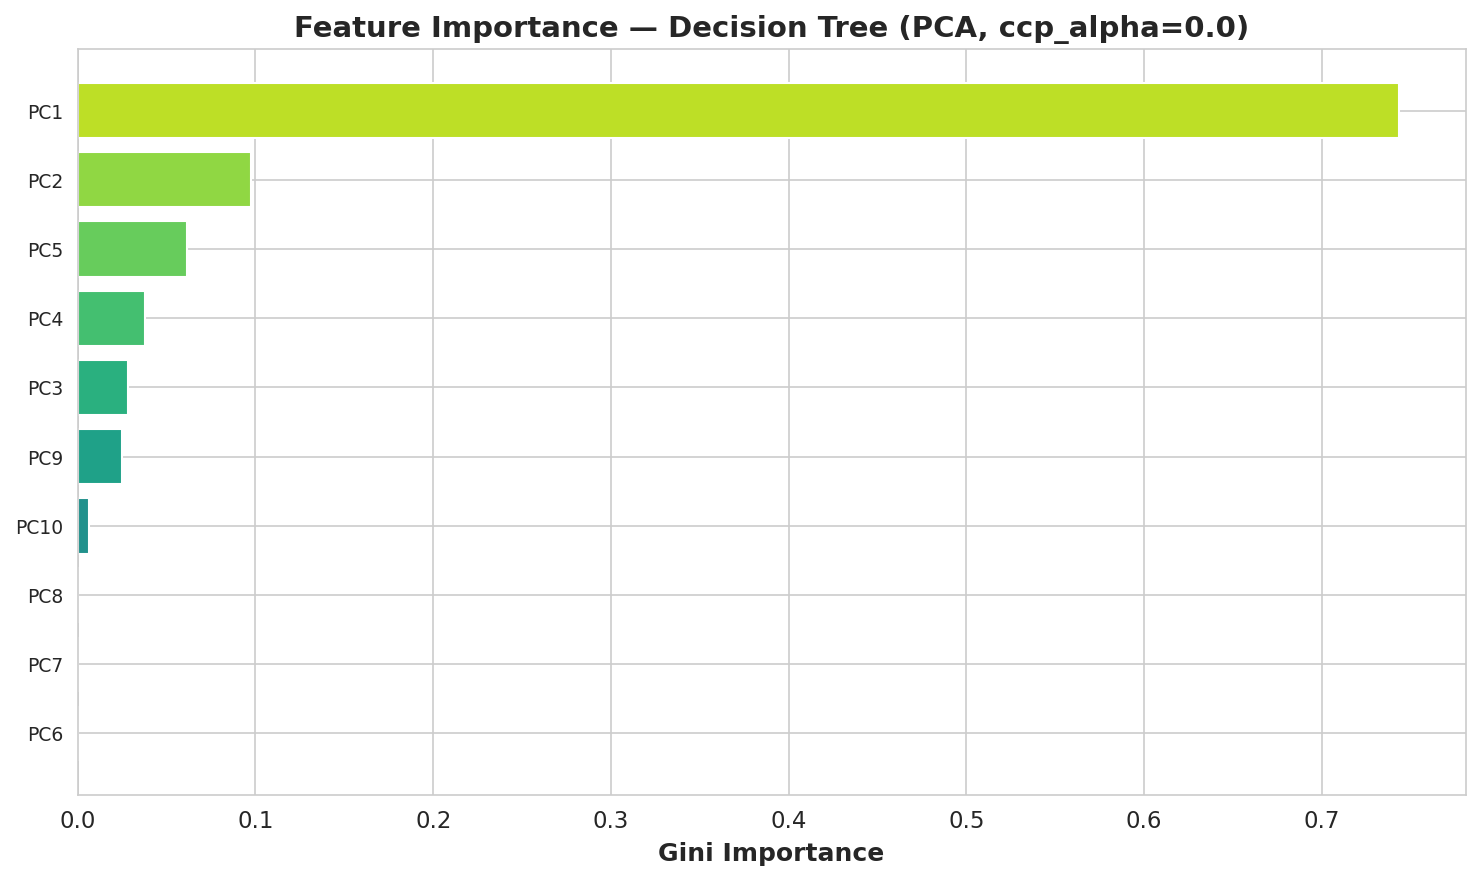

In [200]:
# --- Decision Tree: feature_importances_ sulle Componenti Principali ---
dt_model = best_models['Decision Tree (CART)']
n_comp = dt_model.named_steps['pca'].n_components_
feature_names = [f'PC{i+1}' for i in range(n_comp)]
importances = dt_model.named_steps['classifier'].feature_importances_

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Parametro ccp_alpha selezionato dal GridSearchCV
best_ccp = dt_model.named_steps['classifier'].ccp_alpha
best_depth = dt_model.named_steps['classifier'].get_depth()
print(f'Pruning: ccp_alpha={best_ccp}, profondita\' effettiva={best_depth}')
print()

print('Feature Importance — Decision Tree (CART) su Componenti Principali:')
for i, (_, row) in enumerate(fi_df.iterrows(), 1):
    print(f'  {i:2d}. {row["Feature"]:<10s} {row["Importance"]:.4f}')

# Grafico
fig, ax = plt.subplots(figsize=(10, 6))
fi_sorted = fi_df.sort_values('Importance')
ax.barh(range(len(fi_sorted)), fi_sorted['Importance'],
        color=plt.cm.viridis(np.linspace(0.3, 0.9, len(fi_sorted))))
ax.set_yticks(range(len(fi_sorted)))
ax.set_yticklabels(fi_sorted['Feature'], fontsize=9)
ax.set_xlabel('Gini Importance', fontweight='bold')
ax.set_title(f'Feature Importance — Decision Tree (PCA, ccp_alpha={best_ccp})', fontweight='bold')
plt.tight_layout()
plt.savefig('10_feature_importance_dt.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.4 Visualizzazione Albero Decisionale

Uno dei vantaggi principali di CART: il modello e' completamente interpretabile.

Regole dell'albero (prime righe):
|--- PC1 <= -0.10
|   |--- PC1 <= -1.14
|   |   |--- PC1 <= -2.41
|   |   |   |--- class: 0
|   |   |--- PC1 >  -2.41
|   |   |   |--- PC2 <= -0.31
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- PC2 >  -0.31
|   |   |   |   |--- class: 0
|   |--- PC1 >  -1.14
|   |   |--- PC4 <= 0.27
|   |   |   |--- PC8 <= -0.69
|   |   |   |   |--- class: 0
|   |   |   |--- PC8 >  -0.69
|   |   |   |   |--- class: 0
|   |   |--- PC4 >  0.27
|   |   |   |--- PC5 <= -0.84
|   |   |   |   |--- class: 0
|   |   |   |--- PC5 >  -0.84
|   |   |   |   |--- truncated branch of depth 2
|--- PC1 >  -0.10
|   |--- PC2 <= 1.05
|   |   |--- PC1 <= 0.25
|   |   |   |--- class: 1
|   |   |--- PC1 >  0.25
|   |   |   |--- PC7 <= -2.57
|   |   |   |   |--- class: 1
|   |   |   |--- PC7 >  -2.57
|   |   |   |   |--- class: 1
|   |--- PC2 >  1.05
|   |   |--- PC1 <= 2.35
|   |   |   |--- PC3 <= -0.83
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- P

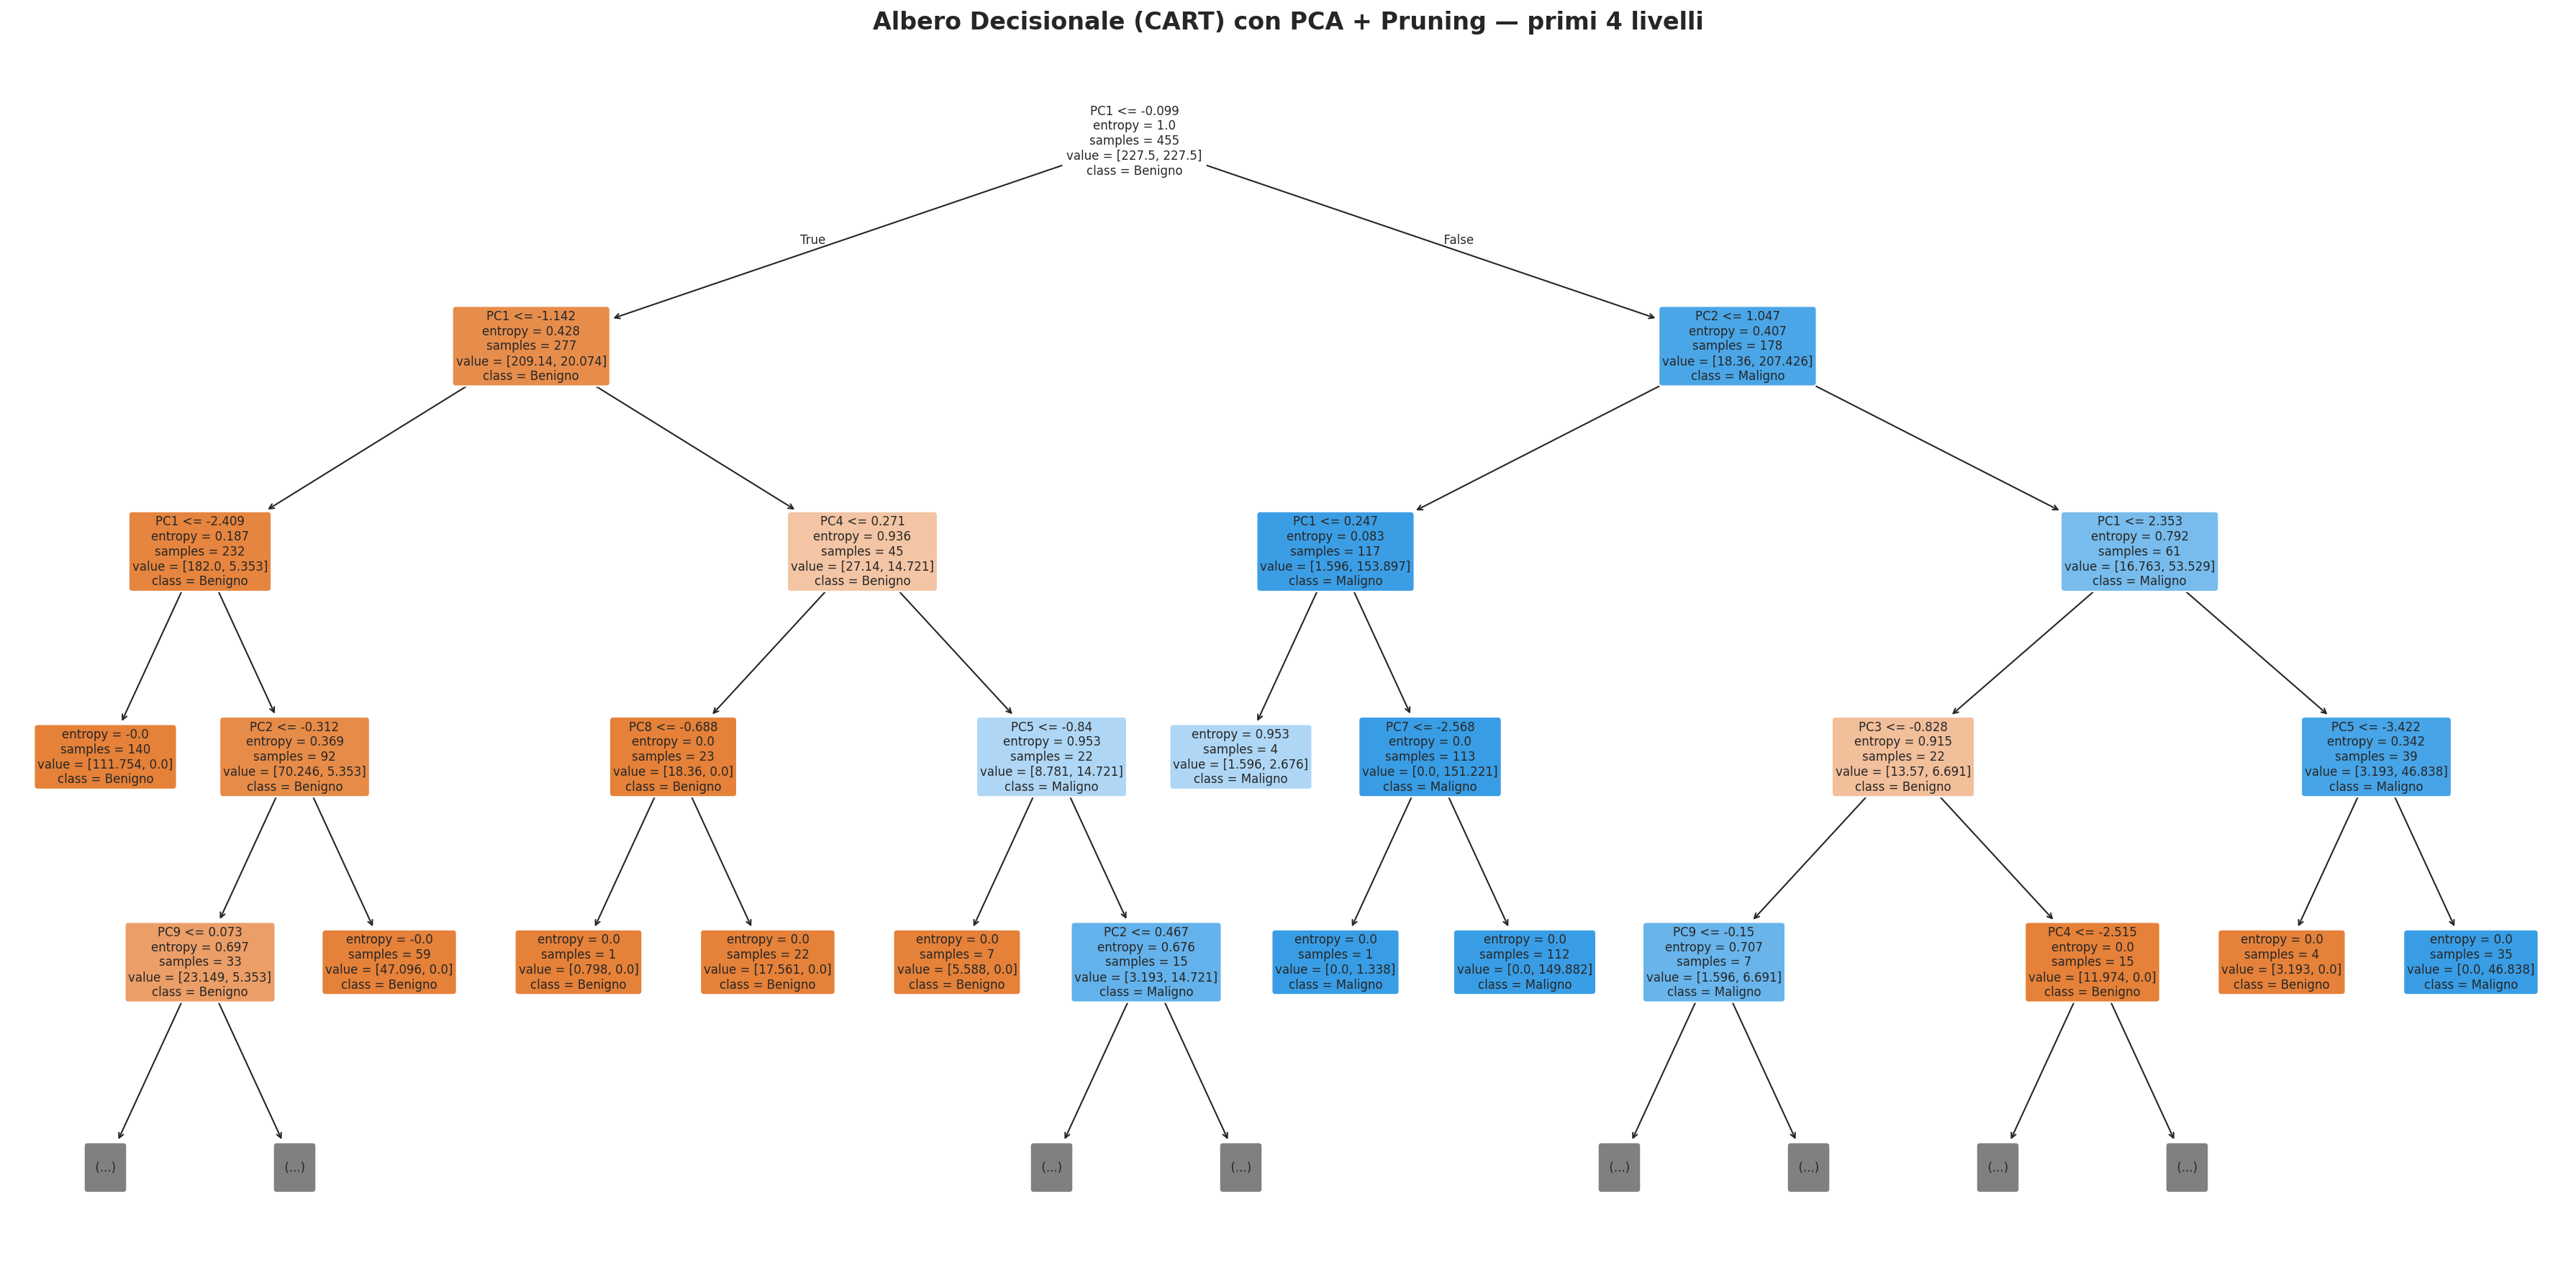

In [201]:
dt_classifier = dt_model.named_steps['classifier']
n_comp = dt_model.named_steps['pca'].n_components_
feat_names = [f'PC{i+1}' for i in range(n_comp)]

# Regole testuali
print('Regole dell\'albero (prime righe):')
rules = export_text(dt_classifier, feature_names=feat_names, max_depth=3)
print(rules)

# Grafico dell'albero
fig, ax = plt.subplots(figsize=(24, 12))
plot_tree(
    dt_classifier,
    feature_names=feat_names,
    class_names=['Benigno', 'Maligno'],
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=4,
    ax=ax
)
ax.set_title('Albero Decisionale (CART) con PCA + Pruning — primi 4 livelli', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.savefig('11_albero_decisionale.png', dpi=200, bbox_inches='tight')
plt.show()

### 7.5 Confronto CV vs Test (Overfitting Check)

In [202]:
# Ri-validazione con i modelli TUNED per un confronto corretto
# (la cross_validate precedente usava iperparametri di default,
#  mentre il test set e' stato valutato con i modelli ottimizzati da GridSearchCV)
print('Confronto metriche CV (modelli tuned) vs Test Set:')
print('Se le metriche test sono molto inferiori alla CV -> overfitting')
print()

cv_check = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_results_tuned = {}

for i, name in enumerate(best_models.keys()):
    cv_res_tuned = cross_validate(
        best_models[name], X_train, y_train,
        cv=cv_check,
        scoring=['accuracy', 'f1'],
        n_jobs=-1
    )
    cv_results_tuned[name] = cv_res_tuned

    cv_acc = cv_res_tuned['test_accuracy'].mean()
    cv_acc_std = cv_res_tuned['test_accuracy'].std()
    cv_f1 = cv_res_tuned['test_f1'].mean()
    cv_f1_std = cv_res_tuned['test_f1'].std()
    test_f1 = results_df.iloc[i]['F1-Score']
    test_acc = results_df.iloc[i]['Accuracy']

    print(f'{name}:')
    print(f'  Accuracy:  CV={cv_acc:.4f} +/- {cv_acc_std:.4f}  Test={test_acc:.4f}  (diff={test_acc-cv_acc:+.4f})')
    print(f'  F1-Score:  CV={cv_f1:.4f} +/- {cv_f1_std:.4f}  Test={test_f1:.4f}  (diff={test_f1-cv_f1:+.4f})')
    print()

Confronto metriche CV (modelli tuned) vs Test Set:
Se le metriche test sono molto inferiori alla CV -> overfitting

SVM (RBF):
  Accuracy:  CV=0.9780 +/- 0.0171  Test=0.9825  (diff=+0.0045)
  F1-Score:  CV=0.9705 +/- 0.0229  Test=0.9756  (diff=+0.0051)

Decision Tree (CART):
  Accuracy:  CV=0.9406 +/- 0.0330  Test=0.9474  (diff=+0.0068)
  F1-Score:  CV=0.9213 +/- 0.0460  Test=0.9286  (diff=+0.0073)



### 7.6 Analisi Non Supervisionata — K-Means + PCA

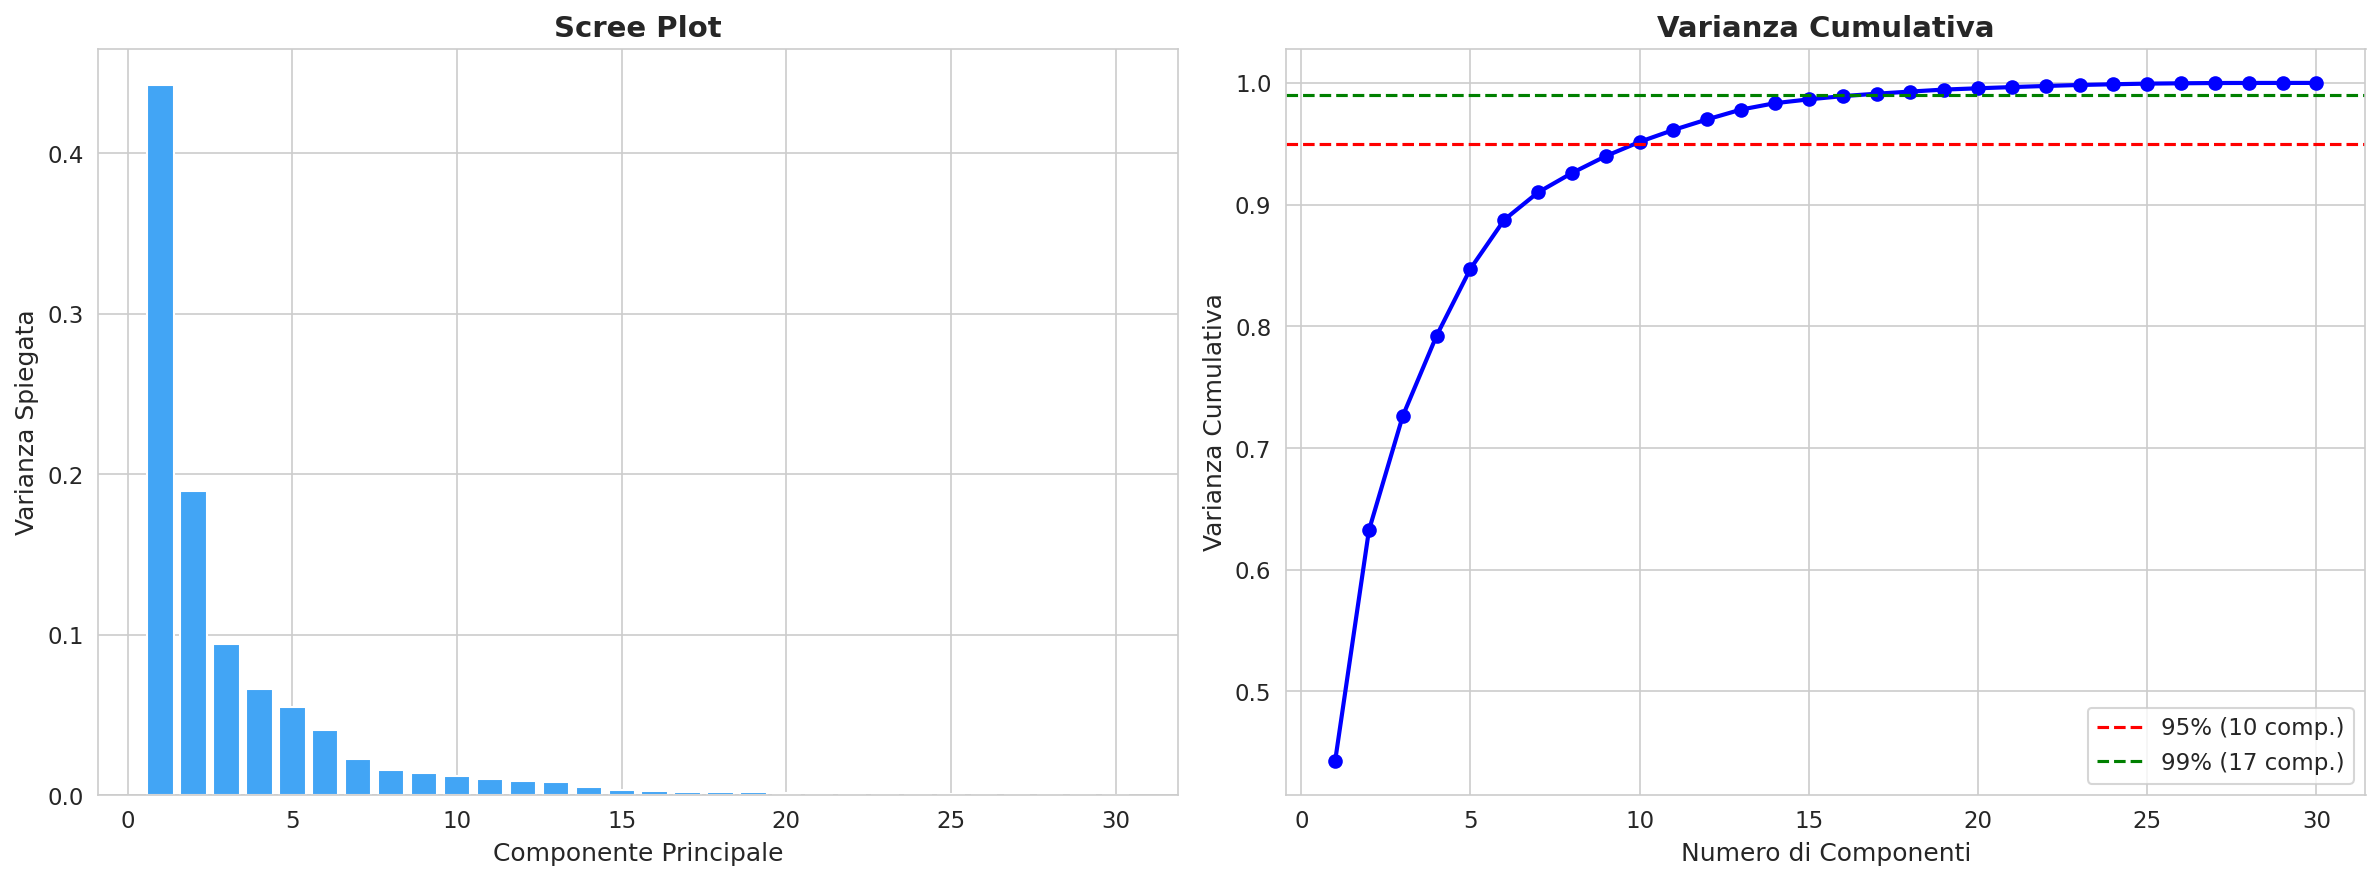

Componenti per 95% varianza: 10
Componenti per 99% varianza: 17
Varianza prime 2 componenti: 63.24%


In [203]:
# Scaling su tutto il dataset (analisi unsupervised separata)
scaler_unsup = StandardScaler()  # Istanza separata, non sovrascriviamo lo scaler della pipeline
X_scaled_all = scaler_unsup.fit_transform(X)

# --- PCA: varianza spiegata ---
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled_all)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

n_95 = np.argmax(cumvar >= 0.95) + 1
n_99 = np.argmax(cumvar >= 0.99) + 1

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, color='#42A5F5', edgecolor='white')
axes[0].set_xlabel('Componente Principale')
axes[0].set_ylabel('Varianza Spiegata')
axes[0].set_title('Scree Plot', fontweight='bold')

axes[1].plot(range(1, len(cumvar) + 1), cumvar, 'bo-', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label=f'95% ({n_95} comp.)')
axes[1].axhline(y=0.99, color='g', linestyle='--', label=f'99% ({n_99} comp.)')
axes[1].set_xlabel('Numero di Componenti')
axes[1].set_ylabel('Varianza Cumulativa')
axes[1].set_title('Varianza Cumulativa', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('12_pca_varianza.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Componenti per 95% varianza: {n_95}')
print(f'Componenti per 99% varianza: {n_99}')
print(f'Varianza prime 2 componenti: {cumvar[1]*100:.2f}%')

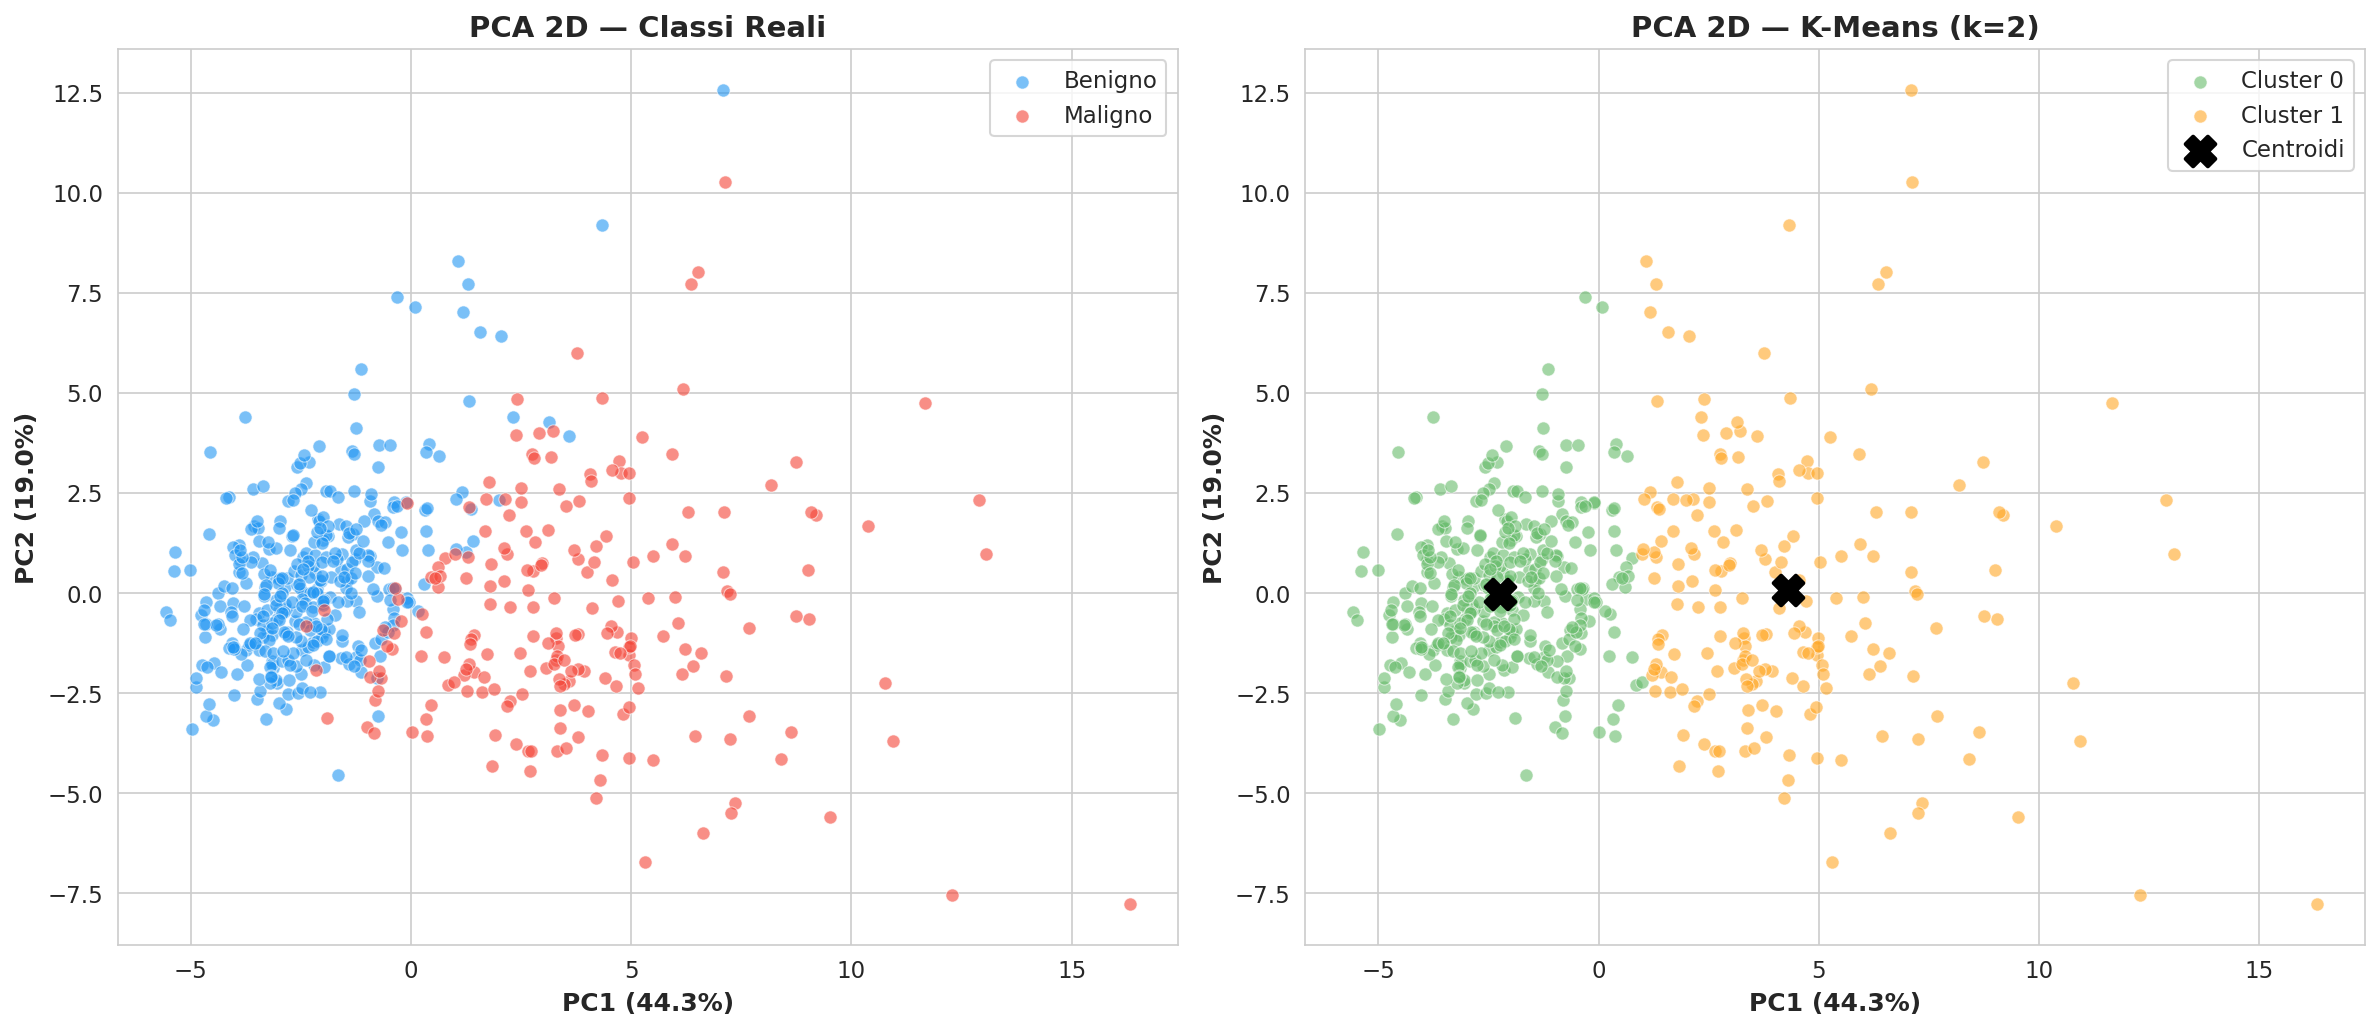

Silhouette Score: 0.3434 (range [-1, 1])
Adjusted Rand Index: 0.6536 (1 = perfetto accordo con classi reali)


In [204]:
# --- PCA 2D + K-Means ---
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca_2d.fit_transform(X_scaled_all)

kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_scaled_all)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Classi reali
for cls, color, label in [(0, '#2196F3', 'Benigno'), (1, '#F44336', 'Maligno')]:
    mask = y == cls
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=label,
                    alpha=0.6, s=40, edgecolors='white', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
axes[0].set_title('PCA 2D — Classi Reali', fontweight='bold')
axes[0].legend()

# Cluster K-Means
for cl, color, label in [(0, '#66BB6A', 'Cluster 0'), (1, '#FFA726', 'Cluster 1')]:
    mask = clusters == cl
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=label,
                    alpha=0.6, s=40, edgecolors='white', linewidth=0.5)
centroids_pca = pca_2d.transform(kmeans.cluster_centers_)
axes[1].scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='black',
                marker='X', s=200, linewidths=2, label='Centroidi')
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
axes[1].set_title('PCA 2D — K-Means (k=2)', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('13_pca_kmeans.png', dpi=300, bbox_inches='tight')
plt.show()

sil = silhouette_score(X_scaled_all, clusters)
ari = adjusted_rand_score(y, clusters)
print(f'Silhouette Score: {sil:.4f} (range [-1, 1])')
print(f'Adjusted Rand Index: {ari:.4f} (1 = perfetto accordo con classi reali)')

In [205]:
# Tabella di contingenza
contingency = pd.crosstab(
    pd.Series(y, name='Classe Reale').map({0: 'Benigno', 1: 'Maligno'}),
    pd.Series(clusters, name='Cluster').map({0: 'Cluster 0', 1: 'Cluster 1'}),
    margins=True
)
print('Tabella di contingenza K-Means vs Classi Reali:')
display(contingency)

Tabella di contingenza K-Means vs Classi Reali:


Cluster       Cluster 0  Cluster 1  All
Classe Reale                           
Benigno             339         18  357
Maligno              36        176  212
All                 375        194  569

### 7.7 Tabella Riassuntiva Finale

In [206]:
# Tabella riassuntiva con CV dei modelli TUNED (coerente con il test set)
final_summary = []
for i, name in enumerate(pipelines.keys()):
    row = {
        'Modello': name,
        'CV Accuracy (tuned)': f"{cv_results_tuned[name]['test_accuracy'].mean():.4f} +/- {cv_results_tuned[name]['test_accuracy'].std():.4f}",
        'CV F1 (tuned)': f"{cv_results_tuned[name]['test_f1'].mean():.4f} +/- {cv_results_tuned[name]['test_f1'].std():.4f}",
        'Test Accuracy': f"{results_df.iloc[i]['Accuracy']:.4f}",
        'Test Precision': f"{results_df.iloc[i]['Precision']:.4f}",
        'Test Recall': f"{results_df.iloc[i]['Recall']:.4f}",
        'Test F1': f"{results_df.iloc[i]['F1-Score']:.4f}",
        'Test ROC-AUC': f"{results_df.iloc[i]['ROC-AUC']:.4f}",
    }
    final_summary.append(row)

final_df = pd.DataFrame(final_summary)
display(final_df)

final_df.to_csv('risultati_completi.csv', index=False)
print('Risultati salvati in risultati_completi.csv')

Modello CV Accuracy (tuned)      CV F1 (tuned) Test Accuracy  \
0             SVM (RBF)   0.9780 +/- 0.0171  0.9705 +/- 0.0229        0.9825   
1  Decision Tree (CART)   0.9406 +/- 0.0330  0.9213 +/- 0.0460        0.9474   

  Test Precision Test Recall Test F1 Test ROC-AUC  
0         1.0000      0.9524  0.9756       0.9974  
1         0.9286      0.9286  0.9286       0.9555

Risultati salvati in risultati_completi.csv


---
## 8. Conclusions

### 8.1 Sintesi dei Risultati

**Analisi Esplorativa:**
- Il dataset (569 campioni, 30 feature numeriche) non presenta missing values ne' feature categoriche
- Imbalance moderato (63% B / 37% M) gestito con `class_weight='balanced'`
- Forte correlazione tra feature della stessa famiglia (radius/perimeter/area)

**Modelli Supervisionati:**
- **SVM (RBF)** raggiunge le performance migliori, coerentemente con le caratteristiche del dataset (feature continue, alta dimensionalita' relativa)
- **Decision Tree (CART)** ha performance inferiori ma offre interpretabilita' completa — il medico puo' leggere le regole decisionali dell'albero
- Il confronto CV vs Test non evidenzia overfitting significativo in nessuno dei due modelli

**Analisi Non Supervisionata:**
- K-Means identifica 2 cluster coerenti con le classi reali (ARI riportato sopra)
- Le prime 2 componenti PCA spiegano oltre il 60% della varianza totale
- Questo conferma l'ipotesi di separabilita' naturale formulata nell'EDA

### 8.2 Trade-off Performance vs Interpretabilita'

| Aspetto | SVM (RBF) | Decision Tree (CART) |
|---------|-----------|---------------------|
| Performance | Superiore | Inferiore |
| Interpretabilita' | Black box | White box (regole leggibili) |
| Scaling necessario | Si | No |
| Robustezza a outlier | Buona (soft margin) | Media (pruning) |

In ambito clinico, la scelta finale dipenderebbe dal contesto:
- **Screening di massa**: SVM, per massimizzare la recall
- **Supporto alla decisione clinica**: CART, per la trasparenza del processo decisionale

### 8.3 Limitazioni

1. Dataset monocentrico (569 campioni da un singolo ospedale)
2. Nessuna validazione esterna su dataset indipendenti
3. Assenza di variabili demografiche (eta', etnia)
4. Ridondanza tra le 30 feature (derivate da 10 misure base)

### 8.4 Sviluppi Futuri

- **Feature selection**: ridurre la ridondanza con tecniche come RFE o L1 regularization
- **Validazione multicentrica**: testare i modelli su dati provenienti da altri ospedali
- **Explainability per SVM**: applicare SHAP o LIME per rendere interpretabili le predizioni di SVM

---
## Riferimenti

1. Wolberg, W.H., Street, W.N., & Mangasarian, O.L. (1995). *Image Analysis and Machine Learning Applied to Breast Cancer Diagnosis and Prognosis.*
2. Street, W.N., Wolberg, W.H., & Mangasarian, O.L. (1993). *Nuclear Feature Extraction for Breast Tumor Diagnosis.*
3. UCI Machine Learning Repository — Breast Cancer Wisconsin (Diagnostic) Dataset. https://archive.ics.uci.edu/dataset/17/
4. Pedregosa, F. et al. (2011). *Scikit-learn: Machine Learning in Python.* JMLR, 12, 2825-2830.